# Trading Strategy

Using the AE and LSTM models that were trained and evaluated in previous steps, a trading strategy can be developed using the same data sets. 

The steps will be as follows: 
- Using the AE model, the most representative company(s) will be identified over a 5 year time period
- The one month performance will be predicted using the previous 3 months data
- The one month performance of the S&P 500 will also be predicted using the previous 3 months
- If the company performance is expected to perform better than the S&P 500, a long position in the company and a short position in the S&P 500 index will be taken. And vice-versa. 
- The performance of the strategy will be measured against the S&P 500 performance? 

## Libraries 

In [47]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import ast
import pickle
from datetime import datetime, timedelta
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose

import keras
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from keras import regularizers
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score

## Data Import and Preprocessing

The same datasets will be used: 
- The share price data for the S&P 500 constituents, 
- and the S&P 500 itself
- The analyst estimates data for the S&P 500 constituents
- The index constituents data per month 
- The mapping table to convert ISIN to RIC to Common Company Name


In [2]:
## import the price data
prices_df = pd.read_csv(
    '../Data/ds_spx_1990-2020_survivorship_free_prices.csv',
    index_col = 0,
    parse_dates = True,
    ).dropna(axis=1, how='all').astype('float32')

## import S&P index price
spx_df = pd.read_csv(
    '../Data/ds_spx_1973-2020_index.csv',
    index_col = 0,
    parse_dates = True,
    ).dropna(axis=1, how='all').astype('float32')

## import the mapping table 
map_df = pd.read_csv(
    '../Data/eikon_map_table.csv', 
    index_col = 0
    )

## import the index constituents data
constituents_df = pd.read_csv(
    '../Data/eikon_spx_constituents_1995.csv', 
    index_col = 0, 
    parse_dates = True
    )
constituents_df['Index Constituents'] = constituents_df['Index Constituents'].apply(ast.literal_eval)

## import the IBES analysts estimates data
estimates_df = pd.read_csv(
        '../Data/eikon_ibes_data_1995.csv',
        index_col = 0,
        parse_dates = True, 
)#.fillna(method = 'ffill').dropna(axis = 1, how = 'any')

In [3]:
## consistent date range across the time-series data
s_date = '2005-01-01'
e_date = '2009-12-31'

prices_df = prices_df.loc[s_date:e_date, :]
spx_df = spx_df.loc[s_date:e_date, :]
estimates_df = estimates_df.loc[s_date:e_date, :]

Its always useful to visually inspect the test data set first. This time period shows a general positive trend with a few periods of volatility. There is perhaps more volatility towards the end of the period, so it will be interesting to see how the model performs. 

The test period of 5 years was deemed to be suitable considering the autoencoder constraints discussed below and in previous chapters regarding missing values. At 5 years, there is a decent period of information for a model to indentify some latent relationships in training. It is also not too long that it means that too many important companies with shorter existence will be excluded. 

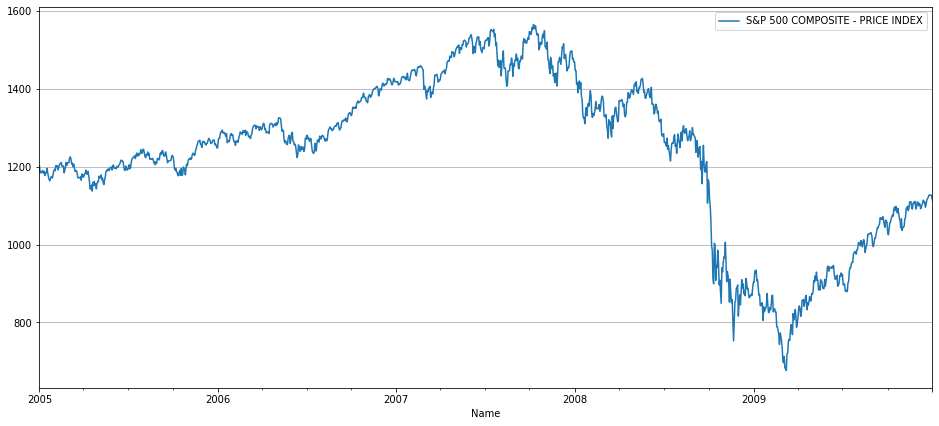

In [4]:
spx_df.plot(figsize = (16, 7))
plt.grid(axis = 'y');

In [5]:
## formatting the column titles for estimates_df
estimates_df.columns = [
    'RIC',
    'Number of Analysts', 
    'Earnings Per Share FY0 - Actual',
    'Earnings Per Share FY0 - Mean', 
    'Earnings Per Share FY1 - Mean',
    'Earnings Per Share FY2 - Mean', 
    'Earnings Per Share FQ0 - Actual',
    'Earnings Per Share FQ0 - Mean', 
    'Earnings Per Share FQ1 - Mean',
    'Earnings Per Share FQ2 - Mean', 
    'Earnings Per Share FQ3 - Mean',
    'Earnings Per Share FQ4 - Mean'
]

Additional datasets will need to be created:
- S&P 500 constituents share price returns
- S&P 500 index returns 

In [6]:
returns_df = prices_df.pct_change()
returns_df.iloc[0, :] = 0

spx_returns_df = spx_df.pct_change()
spx_returns_df.iloc[0, :] = 0

For the `prices_df` and `returns_df` dataframes, the values for companies that were not members of the S&P 500 index at a given period will be changed to NaN values. Before the autoencoder is trained, only companies that have no NaN values over the entire period under examination will be considered. This is due to the issues that the autoencoder model faces when learning on a dataset containing several NaN values. These companies can easily be dropped from the dataframe if the value is NaN

In [7]:
## create a monthly date range to access index constituents form constituents_df
dates = pd.date_range(s_date, e_date, freq = 'BM').strftime('%Y-%m')

for month in dates: 
    constituents = constituents_df.loc[month, 'Index Constituents'].values[0]
    isin_codes = map_df.loc[constituents, 'ISIN'].values
    not_in_index = [company for company in prices_df[month].columns if company not in isin_codes]
    prices_df.loc[month, not_in_index] = np.nan
    returns_df.loc[month, not_in_index] = np.nan

# The autoencoder 

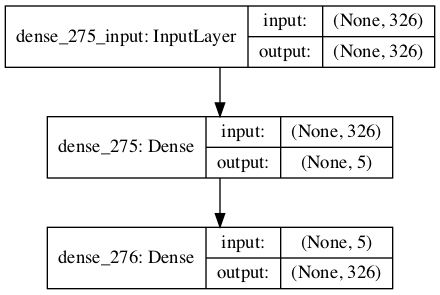

In [8]:
ae_model = load_model('model/ae_model_wo_reg_2020_08_27.h5')

# keras.utils.vis_utils.pydot
plot_model(ae_model, to_file = 'images/ae_model.png', show_shapes = True,)# show_layer_names = True)

The number of companies and the specific companies are likely to change at each moving window, so we are unable to use the exact model trained previously. Instead, at each time period (monthly) the weights will be retrained. The hyperparameters used to train the original model can be used on each new model. They are as follows: 

`{'batch_size': 5, 'lr': 0.0001, 'n_nodes_list': (5,)}`

In [9]:
def create_model(
    n_companies,
    n_nodes_list = (5,), 
    penalty = 0.0, 
    act_funct = 'relu', 
    lr = 0.0001, 
):
    
    model = Sequential()
    i = 0
    
    for layer in n_nodes_list:
        if i == 0:
            model.add(Dense(
                layer, 
                activation = act_funct, 
                kernel_regularizer = regularizers.l2(penalty),
                input_shape = (n_companies, )
                     ))
        else:
            model.add(Dense(
                n_nodes_list[layer], 
                activation = act_funct,
                kernel_regularizer = regularizers.l2(penalty)      
                     ))
        i += 0
    
    opt = Adam(learning_rate = lr)
    model.add(Dense(n_companies, activation = 'linear', kernel_regularizer = regularizers.l2(penalty)))
    model.compile(optimizer = opt, loss = 'mse')
    
    return model

This means that a new autoencoder will need to be trained for every month. These models will be trained and stored in the dictionary `ae_models_dict` with the keys relating to the month the LSTM model will be trying to predict. So if the LSTM was trying to predict the returns for 01-2016, the autoencoder for that will be using returns data from 01-01-2010 to 31-12-2015.

In [10]:
import_ae_models_dict = False

if import_ae_models_dict:
    
    filename = 'model/ae_models_dict_2020_08_28.pkl' # or change the date

    infile = open(filename,'rb')
    ae_models_dict = pickle.load(infile)
    infile.close()
    
else:

    ae_models_dict = {}
    early_stopping = EarlyStopping(monitor = 'loss', patience = 5)

    for m in range(len(dates[:-48])):

        # get the data for the preceeding 60 month period and drop companies with any NaN values
        df = copy.deepcopy(returns_df[dates[m]:dates[m+47]])
        df = df.dropna(axis = 1, how = 'any').astype('float32')

        # compile and fit the autoencoder
        n_companies = df.shape[1]
        ae_model = create_model(n_companies)
        ae_model.fit(
            df, 
            df, 
            shuffle = False, 
            batch_size = 5,
            epochs = 500,
            callbacks = [early_stopping]
        )

        # predict the reconstructed data
        recon_df = pd.DataFrame(
            ae_model.predict(df), 
            index = df.index, 
            columns = df.columns
        )
        
        # create a dataframe with the reconstruction errors per company
        mse_df = pd.DataFrame()
        for co in df.columns:
            mse_df.loc[co, 'mse'] = mean_squared_error(df[co], recon_df[co])

        ae_models_dict[dates[m+48]] = ae_model, recon_df, mse_df

Epoch 1/500
1043/1043 [==============================] - 0s 228us/step - loss: 6.3032e-04
Epoch 2/500
1043/1043 [==============================] - 0s 142us/step - loss: 6.2089e-04
Epoch 3/500
1043/1043 [==============================] - 0s 154us/step - loss: 6.0297e-04
Epoch 4/500
1043/1043 [==============================] - 0s 153us/step - loss: 5.7400e-04
Epoch 5/500
1043/1043 [==============================] - 0s 191us/step - loss: 5.3942e-04
Epoch 6/500
1043/1043 [==============================] - 0s 141us/step - loss: 5.0576e-04
Epoch 7/500
1043/1043 [==============================] - 0s 144us/step - loss: 4.7679e-04
Epoch 8/500
1043/1043 [==============================] - 0s 124us/step - loss: 4.5407e-04
Epoch 9/500
1043/1043 [==============================] - 0s 128us/step - loss: 4.3688e-04
Epoch 10/500
1043/1043 [==============================] - 0s 143us/step - loss: 4.2402e-04
Epoch 11/500
1043/1043 [==============================] - 0s 126us/step - loss: 4.1433e-04
Epoch 12

1043/1043 [==============================] - 0s 139us/step - loss: 3.2302e-04
Epoch 92/500
1043/1043 [==============================] - 0s 176us/step - loss: 3.2274e-04
Epoch 93/500
1043/1043 [==============================] - 0s 159us/step - loss: 3.2248e-04
Epoch 94/500
1043/1043 [==============================] - 0s 138us/step - loss: 3.2223e-04
Epoch 95/500
1043/1043 [==============================] - 0s 157us/step - loss: 3.2198e-04
Epoch 96/500
1043/1043 [==============================] - 0s 141us/step - loss: 3.2175e-04
Epoch 97/500
1043/1043 [==============================] - 0s 132us/step - loss: 3.2153e-04
Epoch 98/500
1043/1043 [==============================] - 0s 155us/step - loss: 3.2131e-04
Epoch 99/500
1043/1043 [==============================] - 0s 155us/step - loss: 3.2111e-04
Epoch 100/500
1043/1043 [==============================] - 0s 149us/step - loss: 3.2091e-04
Epoch 101/500
1043/1043 [==============================] - 0s 115us/step - loss: 3.2071e-04
Epoch 102/

1043/1043 [==============================] - 0s 130us/step - loss: 3.1150e-04
Epoch 181/500
1043/1043 [==============================] - 0s 134us/step - loss: 3.1142e-04
Epoch 182/500
1043/1043 [==============================] - 0s 141us/step - loss: 3.1132e-04
Epoch 183/500
1043/1043 [==============================] - 0s 138us/step - loss: 3.1122e-04
Epoch 184/500
1043/1043 [==============================] - 0s 126us/step - loss: 3.1112e-04
Epoch 185/500
1043/1043 [==============================] - 0s 193us/step - loss: 3.1103e-04
Epoch 186/500
1043/1043 [==============================] - 0s 275us/step - loss: 3.1094e-04
Epoch 187/500
1043/1043 [==============================] - 0s 269us/step - loss: 3.1083e-04
Epoch 188/500
1043/1043 [==============================] - 0s 210us/step - loss: 3.1074e-04
Epoch 189/500
1043/1043 [==============================] - 0s 189us/step - loss: 3.1064e-04
Epoch 190/500
1043/1043 [==============================] - 0s 224us/step - loss: 3.1054e-04 0s

Epoch 269/500
1043/1043 [==============================] - 0s 192us/step - loss: 3.0201e-04
Epoch 270/500
1043/1043 [==============================] - 0s 175us/step - loss: 3.0194e-04
Epoch 271/500
1043/1043 [==============================] - 0s 168us/step - loss: 3.0188e-04
Epoch 272/500
1043/1043 [==============================] - 0s 177us/step - loss: 3.0183e-04
Epoch 273/500
1043/1043 [==============================] - 0s 190us/step - loss: 3.0177e-04
Epoch 274/500
1043/1043 [==============================] - 0s 170us/step - loss: 3.0171e-04
Epoch 275/500
1043/1043 [==============================] - 0s 181us/step - loss: 3.0166e-04
Epoch 276/500
1043/1043 [==============================] - 0s 172us/step - loss: 3.0161e-04
Epoch 277/500
1043/1043 [==============================] - 0s 162us/step - loss: 3.0156e-04
Epoch 278/500
1043/1043 [==============================] - 0s 220us/step - loss: 3.0151e-04
Epoch 279/500
1043/1043 [==============================] - 0s 185us/step - loss:

1043/1043 [==============================] - 0s 210us/step - loss: 2.9922e-04
Epoch 358/500
1043/1043 [==============================] - 0s 198us/step - loss: 2.9921e-04
Epoch 359/500
1043/1043 [==============================] - 0s 182us/step - loss: 2.9919e-04
Epoch 360/500
1043/1043 [==============================] - 0s 191us/step - loss: 2.9918e-04
Epoch 361/500
1043/1043 [==============================] - 0s 184us/step - loss: 2.9917e-04
Epoch 362/500
1043/1043 [==============================] - 0s 174us/step - loss: 2.9916e-04
Epoch 363/500
1043/1043 [==============================] - 0s 188us/step - loss: 2.9914e-04
Epoch 364/500
1043/1043 [==============================] - 0s 178us/step - loss: 2.9913e-04
Epoch 365/500
1043/1043 [==============================] - 0s 161us/step - loss: 2.9912e-04
Epoch 366/500
1043/1043 [==============================] - 0s 177us/step - loss: 2.9911e-04
Epoch 367/500
1043/1043 [==============================] - 0s 177us/step - loss: 2.9910e-04
Ep

1043/1043 [==============================] - 0s 189us/step - loss: 2.9850e-04
Epoch 447/500
1043/1043 [==============================] - 0s 189us/step - loss: 2.9850e-04
Epoch 448/500
1043/1043 [==============================] - 0s 164us/step - loss: 2.9850e-04
Epoch 449/500
1043/1043 [==============================] - 0s 214us/step - loss: 2.9849e-04
Epoch 450/500
1043/1043 [==============================] - 0s 187us/step - loss: 2.9849e-04
Epoch 451/500
1043/1043 [==============================] - 0s 172us/step - loss: 2.9849e-04
Epoch 452/500
1043/1043 [==============================] - 0s 173us/step - loss: 2.9848e-04
Epoch 453/500
1043/1043 [==============================] - 0s 169us/step - loss: 2.9848e-04
Epoch 454/500
1043/1043 [==============================] - 0s 169us/step - loss: 2.9847e-04
Epoch 455/500
1043/1043 [==============================] - 0s 188us/step - loss: 2.9847e-04
Epoch 456/500
1043/1043 [==============================] - 0s 222us/step - loss: 2.9846e-04
Ep

1044/1044 [==============================] - 0s 137us/step - loss: 3.8774e-04
Epoch 36/500
1044/1044 [==============================] - 0s 172us/step - loss: 3.8695e-04
Epoch 37/500
1044/1044 [==============================] - 0s 155us/step - loss: 3.8610e-04
Epoch 38/500
1044/1044 [==============================] - 0s 133us/step - loss: 3.8515e-04
Epoch 39/500
1044/1044 [==============================] - 0s 158us/step - loss: 3.8410e-04
Epoch 40/500
1044/1044 [==============================] - 0s 159us/step - loss: 3.8297e-04
Epoch 41/500
1044/1044 [==============================] - 0s 143us/step - loss: 3.8171e-04
Epoch 42/500
1044/1044 [==============================] - 0s 156us/step - loss: 3.8043e-04
Epoch 43/500
1044/1044 [==============================] - 0s 158us/step - loss: 3.7905e-04
Epoch 44/500
1044/1044 [==============================] - 0s 139us/step - loss: 3.7767e-04
Epoch 45/500
1044/1044 [==============================] - 0s 146us/step - loss: 3.7625e-04
Epoch 46/500

1044/1044 [==============================] - 0s 160us/step - loss: 3.1647e-04
Epoch 125/500
1044/1044 [==============================] - 0s 158us/step - loss: 3.1622e-04
Epoch 126/500
1044/1044 [==============================] - 0s 146us/step - loss: 3.1598e-04
Epoch 127/500
1044/1044 [==============================] - 0s 164us/step - loss: 3.1575e-04
Epoch 128/500
1044/1044 [==============================] - 0s 168us/step - loss: 3.1552e-04
Epoch 129/500
1044/1044 [==============================] - 0s 147us/step - loss: 3.1530e-04
Epoch 130/500
1044/1044 [==============================] - 0s 168us/step - loss: 3.1508e-04
Epoch 131/500
1044/1044 [==============================] - 0s 165us/step - loss: 3.1487e-04
Epoch 132/500
1044/1044 [==============================] - 0s 153us/step - loss: 3.1467e-04
Epoch 133/500
1044/1044 [==============================] - 0s 170us/step - loss: 3.1447e-04
Epoch 134/500
1044/1044 [==============================] - 0s 165us/step - loss: 3.1428e-04
Ep

1044/1044 [==============================] - 0s 139us/step - loss: 3.0763e-04
Epoch 214/500
1044/1044 [==============================] - 0s 124us/step - loss: 3.0759e-04
Epoch 215/500
1044/1044 [==============================] - 0s 135us/step - loss: 3.0756e-04
Epoch 216/500
1044/1044 [==============================] - 0s 126us/step - loss: 3.0753e-04
Epoch 217/500
1044/1044 [==============================] - 0s 119us/step - loss: 3.0750e-04
Epoch 218/500
1044/1044 [==============================] - 0s 121us/step - loss: 3.0747e-04
Epoch 219/500
1044/1044 [==============================] - 0s 125us/step - loss: 3.0744e-04
Epoch 220/500
1044/1044 [==============================] - 0s 129us/step - loss: 3.0741e-04
Epoch 221/500
1044/1044 [==============================] - 0s 126us/step - loss: 3.0738e-04
Epoch 222/500
1044/1044 [==============================] - 0s 123us/step - loss: 3.0735e-04
Epoch 223/500
1044/1044 [==============================] - 0s 122us/step - loss: 3.0732e-04
Ep

1044/1044 [==============================] - 0s 183us/step - loss: 3.0611e-04
Epoch 303/500
1044/1044 [==============================] - 0s 182us/step - loss: 3.0610e-04
Epoch 304/500
1044/1044 [==============================] - 0s 190us/step - loss: 3.0609e-04
Epoch 305/500
1044/1044 [==============================] - 0s 176us/step - loss: 3.0608e-04
Epoch 306/500
1044/1044 [==============================] - 0s 165us/step - loss: 3.0608e-04
Epoch 307/500
1044/1044 [==============================] - 0s 177us/step - loss: 3.0607e-04
Epoch 308/500
1044/1044 [==============================] - 0s 180us/step - loss: 3.0606e-04
Epoch 309/500
1044/1044 [==============================] - 0s 172us/step - loss: 3.0605e-04
Epoch 310/500
1044/1044 [==============================] - 0s 168us/step - loss: 3.0604e-04
Epoch 311/500
1044/1044 [==============================] - 0s 206us/step - loss: 3.0604e-04
Epoch 312/500
1044/1044 [==============================] - 0s 196us/step - loss: 3.0603e-04
Ep

1044/1044 [==============================] - 0s 192us/step - loss: 3.0562e-04
Epoch 392/500
1044/1044 [==============================] - 0s 178us/step - loss: 3.0562e-04
Epoch 393/500
1044/1044 [==============================] - 0s 186us/step - loss: 3.0561e-04
Epoch 394/500
1044/1044 [==============================] - 0s 179us/step - loss: 3.0561e-04
Epoch 395/500
1044/1044 [==============================] - 0s 173us/step - loss: 3.0560e-04
Epoch 396/500
1044/1044 [==============================] - 0s 185us/step - loss: 3.0560e-04
Epoch 397/500
1044/1044 [==============================] - 0s 190us/step - loss: 3.0560e-04
Epoch 398/500
1044/1044 [==============================] - 0s 187us/step - loss: 3.0559e-04
Epoch 399/500
1044/1044 [==============================] - 0s 184us/step - loss: 3.0559e-04
Epoch 400/500
1044/1044 [==============================] - 0s 188us/step - loss: 3.0559e-04
Epoch 401/500
1044/1044 [==============================] - 0s 184us/step - loss: 3.0558e-04
Ep

1044/1044 [==============================] - 0s 176us/step - loss: 3.0533e-04
Epoch 481/500
1044/1044 [==============================] - 0s 160us/step - loss: 3.0532e-04
Epoch 482/500
1044/1044 [==============================] - 0s 176us/step - loss: 3.0532e-04
Epoch 483/500
1044/1044 [==============================] - 0s 175us/step - loss: 3.0532e-04
Epoch 484/500
1044/1044 [==============================] - 0s 170us/step - loss: 3.0532e-04
Epoch 485/500
1044/1044 [==============================] - 0s 160us/step - loss: 3.0531e-04
Epoch 486/500
1044/1044 [==============================] - 0s 259us/step - loss: 3.0531e-04
Epoch 487/500
1044/1044 [==============================] - 0s 202us/step - loss: 3.0531e-04
Epoch 488/500
1044/1044 [==============================] - 0s 195us/step - loss: 3.0530e-04
Epoch 489/500
1044/1044 [==============================] - 0s 185us/step - loss: 3.0530e-04
Epoch 490/500
1044/1044 [==============================] - 0s 183us/step - loss: 3.0530e-04
Ep

1044/1044 [==============================] - 0s 144us/step - loss: 3.4647e-04
Epoch 71/500
1044/1044 [==============================] - 0s 159us/step - loss: 3.4583e-04
Epoch 72/500
1044/1044 [==============================] - 0s 158us/step - loss: 3.4518e-04
Epoch 73/500
1044/1044 [==============================] - 0s 134us/step - loss: 3.4455e-04
Epoch 74/500
1044/1044 [==============================] - 0s 163us/step - loss: 3.4392e-04
Epoch 75/500
1044/1044 [==============================] - 0s 165us/step - loss: 3.4326e-04
Epoch 76/500
1044/1044 [==============================] - 0s 152us/step - loss: 3.4263e-04
Epoch 77/500
1044/1044 [==============================] - 0s 163us/step - loss: 3.4202e-04
Epoch 78/500
1044/1044 [==============================] - 0s 166us/step - loss: 3.4141e-04
Epoch 79/500
1044/1044 [==============================] - 0s 144us/step - loss: 3.4083e-04
Epoch 80/500
1044/1044 [==============================] - 0s 167us/step - loss: 3.4026e-04
Epoch 81/500

1044/1044 [==============================] - 0s 188us/step - loss: 3.2387e-04
Epoch 160/500
1044/1044 [==============================] - 0s 182us/step - loss: 3.2382e-04
Epoch 161/500
1044/1044 [==============================] - 0s 201us/step - loss: 3.2377e-04
Epoch 162/500
1044/1044 [==============================] - 0s 197us/step - loss: 3.2371e-04
Epoch 163/500
1044/1044 [==============================] - 0s 180us/step - loss: 3.2366e-04
Epoch 164/500
1044/1044 [==============================] - 0s 175us/step - loss: 3.2361e-04
Epoch 165/500
1044/1044 [==============================] - 0s 172us/step - loss: 3.2357e-04
Epoch 166/500
1044/1044 [==============================] - 0s 173us/step - loss: 3.2352e-04
Epoch 167/500
1044/1044 [==============================] - 0s 175us/step - loss: 3.2346e-04
Epoch 168/500
1044/1044 [==============================] - 0s 182us/step - loss: 3.2342e-04
Epoch 169/500
1044/1044 [==============================] - 0s 186us/step - loss: 3.2337e-04
Ep

1044/1044 [==============================] - 0s 202us/step - loss: 3.2162e-04
Epoch 249/500
1044/1044 [==============================] - 0s 172us/step - loss: 3.2160e-04
Epoch 250/500
1044/1044 [==============================] - 0s 155us/step - loss: 3.2159e-04
Epoch 251/500
1044/1044 [==============================] - 0s 172us/step - loss: 3.2158e-04
Epoch 252/500
1044/1044 [==============================] - 0s 201us/step - loss: 3.2157e-04
Epoch 253/500
1044/1044 [==============================] - 0s 164us/step - loss: 3.2155e-04
Epoch 254/500
1044/1044 [==============================] - 0s 155us/step - loss: 3.2153e-04
Epoch 255/500
1044/1044 [==============================] - 0s 159us/step - loss: 3.2152e-04
Epoch 256/500
1044/1044 [==============================] - 0s 162us/step - loss: 3.2150e-04
Epoch 257/500
1044/1044 [==============================] - 0s 154us/step - loss: 3.2149e-04
Epoch 258/500
1044/1044 [==============================] - 0s 184us/step - loss: 3.2147e-04
Ep

Epoch 337/500
1044/1044 [==============================] - 0s 137us/step - loss: 3.2033e-04
Epoch 338/500
1044/1044 [==============================] - 0s 159us/step - loss: 3.2031e-04
Epoch 339/500
1044/1044 [==============================] - 0s 162us/step - loss: 3.2029e-04
Epoch 340/500
1044/1044 [==============================] - 0s 137us/step - loss: 3.2027e-04
Epoch 341/500
1044/1044 [==============================] - 0s 145us/step - loss: 3.2025e-04
Epoch 342/500
1044/1044 [==============================] - 0s 151us/step - loss: 3.2023e-04
Epoch 343/500
1044/1044 [==============================] - 0s 143us/step - loss: 3.2021e-04
Epoch 344/500
1044/1044 [==============================] - 0s 136us/step - loss: 3.2019e-04
Epoch 345/500
1044/1044 [==============================] - 0s 150us/step - loss: 3.2018e-04
Epoch 346/500
1044/1044 [==============================] - 0s 154us/step - loss: 3.2016e-04
Epoch 347/500
1044/1044 [==============================] - 0s 131us/step - loss:

1044/1044 [==============================] - 0s 141us/step - loss: 3.1375e-04
Epoch 427/500
1044/1044 [==============================] - 0s 159us/step - loss: 3.1370e-04
Epoch 428/500
1044/1044 [==============================] - 0s 151us/step - loss: 3.1364e-04
Epoch 429/500
1044/1044 [==============================] - 0s 131us/step - loss: 3.1358e-04
Epoch 430/500
1044/1044 [==============================] - 0s 151us/step - loss: 3.1353e-04
Epoch 431/500
1044/1044 [==============================] - 0s 153us/step - loss: 3.1348e-04
Epoch 432/500
1044/1044 [==============================] - 0s 130us/step - loss: 3.1342e-04
Epoch 433/500
1044/1044 [==============================] - 0s 150us/step - loss: 3.1338e-04
Epoch 434/500
1044/1044 [==============================] - 0s 153us/step - loss: 3.1332e-04
Epoch 435/500
1044/1044 [==============================] - 0s 134us/step - loss: 3.1327e-04
Epoch 436/500
1044/1044 [==============================] - 0s 147us/step - loss: 3.1322e-04
Ep

1043/1043 [==============================] - 0s 201us/step - loss: 4.3843e-04
Epoch 16/500
1043/1043 [==============================] - 0s 201us/step - loss: 4.3529e-04
Epoch 17/500
1043/1043 [==============================] - 0s 180us/step - loss: 4.3257e-04
Epoch 18/500
1043/1043 [==============================] - 0s 176us/step - loss: 4.3021e-04
Epoch 19/500
1043/1043 [==============================] - 0s 180us/step - loss: 4.2817e-04
Epoch 20/500
1043/1043 [==============================] - 0s 175us/step - loss: 4.2640e-04
Epoch 21/500
1043/1043 [==============================] - 0s 184us/step - loss: 4.2487e-04
Epoch 22/500
1043/1043 [==============================] - 0s 194us/step - loss: 4.2354e-04
Epoch 23/500
1043/1043 [==============================] - 0s 171us/step - loss: 4.2235e-04
Epoch 24/500
1043/1043 [==============================] - 0s 154us/step - loss: 4.2131e-04
Epoch 25/500
1043/1043 [==============================] - 0s 172us/step - loss: 4.2041e-04
Epoch 26/500

1043/1043 [==============================] - 0s 168us/step - loss: 3.7467e-04
Epoch 106/500
1043/1043 [==============================] - 0s 168us/step - loss: 3.7434e-04
Epoch 107/500
1043/1043 [==============================] - 0s 165us/step - loss: 3.7401e-04
Epoch 108/500
1043/1043 [==============================] - 0s 168us/step - loss: 3.7369e-04
Epoch 109/500
1043/1043 [==============================] - 0s 189us/step - loss: 3.7335e-04
Epoch 110/500
1043/1043 [==============================] - 0s 161us/step - loss: 3.7301e-04
Epoch 111/500
1043/1043 [==============================] - 0s 165us/step - loss: 3.7267e-04
Epoch 112/500
1043/1043 [==============================] - 0s 203us/step - loss: 3.7234e-04
Epoch 113/500
1043/1043 [==============================] - 0s 176us/step - loss: 3.7201e-04
Epoch 114/500
1043/1043 [==============================] - 0s 174us/step - loss: 3.7167e-04
Epoch 115/500
1043/1043 [==============================] - 0s 174us/step - loss: 3.7135e-04
Ep

1043/1043 [==============================] - 0s 174us/step - loss: 3.5492e-04
Epoch 194/500
1043/1043 [==============================] - 0s 172us/step - loss: 3.5480e-04
Epoch 195/500
1043/1043 [==============================] - 0s 163us/step - loss: 3.5469e-04
Epoch 196/500
1043/1043 [==============================] - 0s 174us/step - loss: 3.5457e-04
Epoch 197/500
1043/1043 [==============================] - 0s 172us/step - loss: 3.5445e-04
Epoch 198/500
1043/1043 [==============================] - 0s 175us/step - loss: 3.5434e-04
Epoch 199/500
1043/1043 [==============================] - 0s 167us/step - loss: 3.5423e-04
Epoch 200/500
1043/1043 [==============================] - 0s 172us/step - loss: 3.5412e-04
Epoch 201/500
1043/1043 [==============================] - 0s 178us/step - loss: 3.5401e-04
Epoch 202/500
1043/1043 [==============================] - 0s 166us/step - loss: 3.5391e-04
Epoch 203/500
1043/1043 [==============================] - 0s 171us/step - loss: 3.5380e-04
Ep

1043/1043 [==============================] - 0s 174us/step - loss: 3.4564e-04
Epoch 283/500
1043/1043 [==============================] - 0s 171us/step - loss: 3.4555e-04
Epoch 284/500
1043/1043 [==============================] - 0s 168us/step - loss: 3.4547e-04
Epoch 285/500
1043/1043 [==============================] - 0s 174us/step - loss: 3.4539e-04
Epoch 286/500
1043/1043 [==============================] - 0s 167us/step - loss: 3.4531e-04
Epoch 287/500
1043/1043 [==============================] - 0s 167us/step - loss: 3.4523e-04
Epoch 288/500
1043/1043 [==============================] - 0s 157us/step - loss: 3.4515e-04
Epoch 289/500
1043/1043 [==============================] - 0s 167us/step - loss: 3.4508e-04
Epoch 290/500
1043/1043 [==============================] - 0s 201us/step - loss: 3.4501e-04
Epoch 291/500
1043/1043 [==============================] - 0s 173us/step - loss: 3.4493e-04
Epoch 292/500
1043/1043 [==============================] - 0s 175us/step - loss: 3.4486e-04
Ep

1043/1043 [==============================] - 0s 136us/step - loss: 3.4142e-04
Epoch 372/500
1043/1043 [==============================] - 0s 145us/step - loss: 3.4140e-04
Epoch 373/500
1043/1043 [==============================] - 0s 144us/step - loss: 3.4138e-04
Epoch 374/500
1043/1043 [==============================] - 0s 128us/step - loss: 3.4135e-04
Epoch 375/500
1043/1043 [==============================] - 0s 146us/step - loss: 3.4133e-04
Epoch 376/500
1043/1043 [==============================] - 0s 145us/step - loss: 3.4131e-04
Epoch 377/500
1043/1043 [==============================] - 0s 124us/step - loss: 3.4129e-04
Epoch 378/500
1043/1043 [==============================] - 0s 145us/step - loss: 3.4127e-04
Epoch 379/500
1043/1043 [==============================] - 0s 145us/step - loss: 3.4125e-04
Epoch 380/500
1043/1043 [==============================] - 0s 136us/step - loss: 3.4123e-04
Epoch 381/500
1043/1043 [==============================] - 0s 135us/step - loss: 3.4122e-04
Ep

1043/1043 [==============================] - 0s 150us/step - loss: 3.4027e-04
Epoch 461/500
1043/1043 [==============================] - 0s 134us/step - loss: 3.4026e-04
Epoch 462/500
1043/1043 [==============================] - 0s 135us/step - loss: 3.4025e-04
Epoch 463/500
1043/1043 [==============================] - 0s 145us/step - loss: 3.4025e-04
Epoch 464/500
1043/1043 [==============================] - 0s 149us/step - loss: 3.4024e-04
Epoch 465/500
1043/1043 [==============================] - 0s 130us/step - loss: 3.4023e-04
Epoch 466/500
1043/1043 [==============================] - 0s 152us/step - loss: 3.4023e-04
Epoch 467/500
1043/1043 [==============================] - 0s 152us/step - loss: 3.4022e-04
Epoch 468/500
1043/1043 [==============================] - 0s 129us/step - loss: 3.4021e-04
Epoch 469/500
1043/1043 [==============================] - 0s 151us/step - loss: 3.4021e-04
Epoch 470/500
1043/1043 [==============================] - 0s 150us/step - loss: 3.4020e-04
Ep

1044/1044 [==============================] - 0s 116us/step - loss: 4.0615e-04
Epoch 50/500
1044/1044 [==============================] - 0s 171us/step - loss: 4.0506e-04
Epoch 51/500
1044/1044 [==============================] - 0s 199us/step - loss: 4.0403e-04
Epoch 52/500
1044/1044 [==============================] - 0s 188us/step - loss: 4.0301e-04
Epoch 53/500
1044/1044 [==============================] - 0s 186us/step - loss: 4.0205e-04
Epoch 54/500
1044/1044 [==============================] - 0s 190us/step - loss: 4.0115e-04
Epoch 55/500
1044/1044 [==============================] - 0s 211us/step - loss: 4.0028e-04
Epoch 56/500
1044/1044 [==============================] - 0s 213us/step - loss: 3.9944e-04
Epoch 57/500
1044/1044 [==============================] - 0s 206us/step - loss: 3.9864e-04
Epoch 58/500
1044/1044 [==============================] - 0s 229us/step - loss: 3.9786e-04
Epoch 59/500
1044/1044 [==============================] - 0s 190us/step - loss: 3.9711e-04
Epoch 60/500

1044/1044 [==============================] - 0s 170us/step - loss: 3.6751e-04
Epoch 139/500
1044/1044 [==============================] - 0s 187us/step - loss: 3.6736e-04
Epoch 140/500
1044/1044 [==============================] - 0s 171us/step - loss: 3.6722e-04
Epoch 141/500
1044/1044 [==============================] - 0s 155us/step - loss: 3.6708e-04
Epoch 142/500
1044/1044 [==============================] - 0s 166us/step - loss: 3.6695e-04
Epoch 143/500
1044/1044 [==============================] - 0s 166us/step - loss: 3.6681e-04
Epoch 144/500
1044/1044 [==============================] - 0s 158us/step - loss: 3.6668e-04
Epoch 145/500
1044/1044 [==============================] - 0s 163us/step - loss: 3.6656e-04
Epoch 146/500
1044/1044 [==============================] - 0s 166us/step - loss: 3.6643e-04
Epoch 147/500
1044/1044 [==============================] - 0s 166us/step - loss: 3.6631e-04
Epoch 148/500
1044/1044 [==============================] - 0s 158us/step - loss: 3.6619e-04
Ep

1044/1044 [==============================] - 0s 178us/step - loss: 3.6083e-04
Epoch 228/500
1044/1044 [==============================] - 0s 172us/step - loss: 3.6079e-04
Epoch 229/500
1044/1044 [==============================] - 0s 170us/step - loss: 3.6076e-04
Epoch 230/500
1044/1044 [==============================] - 0s 168us/step - loss: 3.6072e-04
Epoch 231/500
1044/1044 [==============================] - 0s 177us/step - loss: 3.6069e-04
Epoch 232/500
1044/1044 [==============================] - 0s 169us/step - loss: 3.6065e-04
Epoch 233/500
1044/1044 [==============================] - 0s 159us/step - loss: 3.6062e-04
Epoch 234/500
1044/1044 [==============================] - 0s 170us/step - loss: 3.6058e-04
Epoch 235/500
1044/1044 [==============================] - 0s 170us/step - loss: 3.6055e-04
Epoch 236/500
1044/1044 [==============================] - 0s 168us/step - loss: 3.6052e-04
Epoch 237/500
1044/1044 [==============================] - 0s 164us/step - loss: 3.6049e-04
Ep

1044/1044 [==============================] - 0s 164us/step - loss: 3.5835e-04
Epoch 317/500
1044/1044 [==============================] - 0s 167us/step - loss: 3.5833e-04
Epoch 318/500
1044/1044 [==============================] - 0s 163us/step - loss: 3.5830e-04
Epoch 319/500
1044/1044 [==============================] - 0s 166us/step - loss: 3.5827e-04
Epoch 320/500
1044/1044 [==============================] - 0s 167us/step - loss: 3.5825e-04
Epoch 321/500
1044/1044 [==============================] - 0s 156us/step - loss: 3.5822e-04
Epoch 322/500
1044/1044 [==============================] - 0s 168us/step - loss: 3.5820e-04
Epoch 323/500
1044/1044 [==============================] - 0s 164us/step - loss: 3.5817e-04
Epoch 324/500
1044/1044 [==============================] - 0s 166us/step - loss: 3.5814e-04
Epoch 325/500
1044/1044 [==============================] - 0s 155us/step - loss: 3.5811e-04
Epoch 326/500
1044/1044 [==============================] - 0s 159us/step - loss: 3.5808e-04
Ep

1044/1044 [==============================] - 0s 137us/step - loss: 3.5006e-04
Epoch 406/500
1044/1044 [==============================] - 0s 134us/step - loss: 3.4996e-04
Epoch 407/500
1044/1044 [==============================] - 0s 147us/step - loss: 3.4986e-04
Epoch 408/500
1044/1044 [==============================] - 0s 143us/step - loss: 3.4977e-04
Epoch 409/500
1044/1044 [==============================] - 0s 126us/step - loss: 3.4968e-04
Epoch 410/500
1044/1044 [==============================] - 0s 143us/step - loss: 3.4959e-04
Epoch 411/500
1044/1044 [==============================] - 0s 142us/step - loss: 3.4950e-04
Epoch 412/500
1044/1044 [==============================] - 0s 123us/step - loss: 3.4941e-04
Epoch 413/500
1044/1044 [==============================] - 0s 145us/step - loss: 3.4932e-04
Epoch 414/500
1044/1044 [==============================] - 0s 144us/step - loss: 3.4923e-04
Epoch 415/500
1044/1044 [==============================] - 0s 135us/step - loss: 3.4915e-04
Ep

1044/1044 [==============================] - 0s 152us/step - loss: 3.4576e-04
Epoch 495/500
1044/1044 [==============================] - 0s 152us/step - loss: 3.4574e-04
Epoch 496/500
1044/1044 [==============================] - 0s 135us/step - loss: 3.4572e-04
Epoch 497/500
1044/1044 [==============================] - 0s 143us/step - loss: 3.4569e-04
Epoch 498/500
1044/1044 [==============================] - 0s 154us/step - loss: 3.4567e-04
Epoch 499/500
1044/1044 [==============================] - 0s 144us/step - loss: 3.4565e-04
Epoch 500/500
1044/1044 [==============================] - 0s 134us/step - loss: 3.4562e-04
Epoch 1/500
1043/1043 [==============================] - 0s 217us/step - loss: 8.1210e-04
Epoch 2/500
1043/1043 [==============================] - 0s 156us/step - loss: 8.0639e-04
Epoch 3/500
1043/1043 [==============================] - 0s 150us/step - loss: 7.8805e-04
Epoch 4/500
1043/1043 [==============================] - 0s 126us/step - loss: 7.3914e-04
Epoch 5/50

1043/1043 [==============================] - 0s 130us/step - loss: 3.9513e-04
Epoch 85/500
1043/1043 [==============================] - 0s 125us/step - loss: 3.9459e-04
Epoch 86/500
1043/1043 [==============================] - 0s 144us/step - loss: 3.9407e-04
Epoch 87/500
1043/1043 [==============================] - 0s 118us/step - loss: 3.9359e-04
Epoch 88/500
1043/1043 [==============================] - 0s 124us/step - loss: 3.9312e-04
Epoch 89/500
1043/1043 [==============================] - 0s 123us/step - loss: 3.9267e-04
Epoch 90/500
1043/1043 [==============================] - 0s 124us/step - loss: 3.9227e-04
Epoch 91/500
1043/1043 [==============================] - 0s 130us/step - loss: 3.9175e-04
Epoch 92/500
1043/1043 [==============================] - 0s 127us/step - loss: 3.9127e-04
Epoch 93/500
1043/1043 [==============================] - 0s 124us/step - loss: 3.9081e-04
Epoch 94/500
1043/1043 [==============================] - 0s 126us/step - loss: 3.9038e-04
Epoch 95/500

1043/1043 [==============================] - 0s 191us/step - loss: 3.7231e-04
Epoch 174/500
1043/1043 [==============================] - 0s 174us/step - loss: 3.7219e-04
Epoch 175/500
1043/1043 [==============================] - 0s 171us/step - loss: 3.7208e-04
Epoch 176/500
1043/1043 [==============================] - 0s 165us/step - loss: 3.7197e-04
Epoch 177/500
1043/1043 [==============================] - 0s 159us/step - loss: 3.7186e-04
Epoch 178/500
1043/1043 [==============================] - 0s 164us/step - loss: 3.7175e-04
Epoch 179/500
1043/1043 [==============================] - 0s 171us/step - loss: 3.7164e-04
Epoch 180/500
1043/1043 [==============================] - 0s 220us/step - loss: 3.7153e-04
Epoch 181/500
1043/1043 [==============================] - 0s 181us/step - loss: 3.7143e-04
Epoch 182/500
1043/1043 [==============================] - 0s 186us/step - loss: 3.7132e-04
Epoch 183/500
1043/1043 [==============================] - 0s 179us/step - loss: 3.7122e-04
Ep

1043/1043 [==============================] - 0s 171us/step - loss: 3.6636e-04
Epoch 263/500
1043/1043 [==============================] - 0s 170us/step - loss: 3.6631e-04
Epoch 264/500
1043/1043 [==============================] - 0s 173us/step - loss: 3.6627e-04
Epoch 265/500
1043/1043 [==============================] - 0s 174us/step - loss: 3.6623e-04
Epoch 266/500
1043/1043 [==============================] - 0s 169us/step - loss: 3.6619e-04
Epoch 267/500
1043/1043 [==============================] - 0s 168us/step - loss: 3.6615e-04
Epoch 268/500
1043/1043 [==============================] - 0s 169us/step - loss: 3.6611e-04
Epoch 269/500
1043/1043 [==============================] - 0s 161us/step - loss: 3.6607e-04
Epoch 270/500
1043/1043 [==============================] - 0s 166us/step - loss: 3.6604e-04
Epoch 271/500
1043/1043 [==============================] - 0s 166us/step - loss: 3.6600e-04
Epoch 272/500
1043/1043 [==============================] - 0s 164us/step - loss: 3.6596e-04
Ep

1043/1043 [==============================] - 0s 149us/step - loss: 3.6417e-04
Epoch 352/500
1043/1043 [==============================] - 0s 152us/step - loss: 3.6416e-04
Epoch 353/500
1043/1043 [==============================] - 0s 130us/step - loss: 3.6414e-04
Epoch 354/500
1043/1043 [==============================] - 0s 149us/step - loss: 3.6413e-04
Epoch 355/500
1043/1043 [==============================] - 0s 148us/step - loss: 3.6412e-04
Epoch 356/500
1043/1043 [==============================] - 0s 133us/step - loss: 3.6410e-04
Epoch 357/500
1043/1043 [==============================] - 0s 147us/step - loss: 3.6409e-04
Epoch 358/500
1043/1043 [==============================] - 0s 150us/step - loss: 3.6408e-04
Epoch 359/500
1043/1043 [==============================] - 0s 142us/step - loss: 3.6407e-04
Epoch 360/500
1043/1043 [==============================] - 0s 141us/step - loss: 3.6405e-04
Epoch 361/500
1043/1043 [==============================] - 0s 156us/step - loss: 3.6404e-04
Ep

1043/1043 [==============================] - 0s 158us/step - loss: 3.6345e-04
Epoch 441/500
1043/1043 [==============================] - 0s 151us/step - loss: 3.6345e-04
Epoch 442/500
1043/1043 [==============================] - 0s 121us/step - loss: 3.6344e-04
Epoch 443/500
1043/1043 [==============================] - 0s 126us/step - loss: 3.6344e-04
Epoch 444/500
1043/1043 [==============================] - 0s 120us/step - loss: 3.6343e-04
Epoch 445/500
1043/1043 [==============================] - 0s 131us/step - loss: 3.6343e-04
Epoch 446/500
1043/1043 [==============================] - 0s 129us/step - loss: 3.6342e-04
Epoch 447/500
1043/1043 [==============================] - 0s 116us/step - loss: 3.6342e-04
Epoch 448/500
1043/1043 [==============================] - 0s 127us/step - loss: 3.6342e-04
Epoch 449/500
1043/1043 [==============================] - 0s 119us/step - loss: 3.6341e-04
Epoch 450/500
1043/1043 [==============================] - 0s 112us/step - loss: 3.6341e-04
Ep

1043/1043 [==============================] - 0s 165us/step - loss: 4.5120e-04
Epoch 30/500
1043/1043 [==============================] - 0s 162us/step - loss: 4.5018e-04
Epoch 31/500
1043/1043 [==============================] - 0s 164us/step - loss: 4.4917e-04
Epoch 32/500
1043/1043 [==============================] - 0s 198us/step - loss: 4.4816e-04
Epoch 33/500
1043/1043 [==============================] - 0s 222us/step - loss: 4.4713e-04
Epoch 34/500
1043/1043 [==============================] - 0s 200us/step - loss: 4.4603e-04
Epoch 35/500
1043/1043 [==============================] - 0s 181us/step - loss: 4.4490e-04
Epoch 36/500
1043/1043 [==============================] - 0s 201us/step - loss: 4.4373e-04
Epoch 37/500
1043/1043 [==============================] - 0s 184us/step - loss: 4.4253e-04
Epoch 38/500
1043/1043 [==============================] - 0s 185us/step - loss: 4.4128e-04
Epoch 39/500
1043/1043 [==============================] - 0s 184us/step - loss: 4.3998e-04
Epoch 40/500

Epoch 119/500
1043/1043 [==============================] - 0s 205us/step - loss: 3.9039e-04
Epoch 120/500
1043/1043 [==============================] - 0s 206us/step - loss: 3.9021e-04
Epoch 121/500
1043/1043 [==============================] - 0s 185us/step - loss: 3.9003e-04
Epoch 122/500
1043/1043 [==============================] - 0s 193us/step - loss: 3.8985e-04
Epoch 123/500
1043/1043 [==============================] - 0s 186us/step - loss: 3.8969e-04
Epoch 124/500
1043/1043 [==============================] - 0s 199us/step - loss: 3.8952e-04
Epoch 125/500
1043/1043 [==============================] - 0s 184us/step - loss: 3.8936e-04
Epoch 126/500
1043/1043 [==============================] - 0s 181us/step - loss: 3.8921e-04
Epoch 127/500
1043/1043 [==============================] - 0s 175us/step - loss: 3.8906e-04
Epoch 128/500
1043/1043 [==============================] - 0s 165us/step - loss: 3.8891e-04
Epoch 129/500
1043/1043 [==============================] - 0s 175us/step - loss:

1043/1043 [==============================] - 0s 179us/step - loss: 3.8038e-04
Epoch 209/500
1043/1043 [==============================] - 0s 177us/step - loss: 3.8029e-04
Epoch 210/500
1043/1043 [==============================] - 0s 160us/step - loss: 3.8019e-04
Epoch 211/500
1043/1043 [==============================] - 0s 176us/step - loss: 3.8009e-04
Epoch 212/500
1043/1043 [==============================] - 0s 156us/step - loss: 3.7998e-04
Epoch 213/500
1043/1043 [==============================] - 0s 142us/step - loss: 3.7988e-04
Epoch 214/500
1043/1043 [==============================] - 0s 163us/step - loss: 3.7977e-04
Epoch 215/500
1043/1043 [==============================] - 0s 157us/step - loss: 3.7966e-04
Epoch 216/500
1043/1043 [==============================] - 0s 134us/step - loss: 3.7955e-04
Epoch 217/500
1043/1043 [==============================] - 0s 151us/step - loss: 3.7943e-04
Epoch 218/500
1043/1043 [==============================] - 0s 153us/step - loss: 3.7931e-04
Ep

Epoch 297/500
1043/1043 [==============================] - 0s 132us/step - loss: 3.7137e-04
Epoch 298/500
1043/1043 [==============================] - 0s 168us/step - loss: 3.7130e-04
Epoch 299/500
1043/1043 [==============================] - 0s 177us/step - loss: 3.7124e-04
Epoch 300/500
1043/1043 [==============================] - 0s 132us/step - loss: 3.7117e-04
Epoch 301/500
1043/1043 [==============================] - 0s 149us/step - loss: 3.7111e-04
Epoch 302/500
1043/1043 [==============================] - 0s 151us/step - loss: 3.7105e-04
Epoch 303/500
1043/1043 [==============================] - 0s 129us/step - loss: 3.7099e-04
Epoch 304/500
1043/1043 [==============================] - 0s 151us/step - loss: 3.7093e-04
Epoch 305/500
1043/1043 [==============================] - 0s 149us/step - loss: 3.7087e-04
Epoch 306/500
1043/1043 [==============================] - 0s 136us/step - loss: 3.7081e-04
Epoch 307/500
1043/1043 [==============================] - 0s 139us/step - loss:

1043/1043 [==============================] - 0s 152us/step - loss: 3.6829e-04
Epoch 387/500
1043/1043 [==============================] - 0s 137us/step - loss: 3.6827e-04
Epoch 388/500
1043/1043 [==============================] - 0s 133us/step - loss: 3.6826e-04
Epoch 389/500
1043/1043 [==============================] - 0s 134us/step - loss: 3.6824e-04
Epoch 390/500
1043/1043 [==============================] - 0s 135us/step - loss: 3.6822e-04
Epoch 391/500
1043/1043 [==============================] - 0s 136us/step - loss: 3.6820e-04
Epoch 392/500
1043/1043 [==============================] - 0s 136us/step - loss: 3.6819e-04
Epoch 393/500
1043/1043 [==============================] - 0s 137us/step - loss: 3.6817e-04
Epoch 394/500
1043/1043 [==============================] - 0s 135us/step - loss: 3.6815e-04
Epoch 395/500
1043/1043 [==============================] - 0s 137us/step - loss: 3.6814e-04
Epoch 396/500
1043/1043 [==============================] - 0s 143us/step - loss: 3.6812e-04
Ep

1043/1043 [==============================] - 0s 233us/step - loss: 3.6751e-04
Epoch 476/500
1043/1043 [==============================] - 0s 294us/step - loss: 3.6750e-04
Epoch 477/500
1043/1043 [==============================] - 0s 204us/step - loss: 3.6750e-04
Epoch 478/500
1043/1043 [==============================] - 0s 193us/step - loss: 3.6749e-04
Epoch 479/500
1043/1043 [==============================] - 0s 202us/step - loss: 3.6749e-04
Epoch 480/500
1043/1043 [==============================] - 0s 198us/step - loss: 3.6748e-04
Epoch 481/500
1043/1043 [==============================] - 0s 189us/step - loss: 3.6748e-04
Epoch 482/500
1043/1043 [==============================] - 0s 185us/step - loss: 3.6747e-04
Epoch 483/500
1043/1043 [==============================] - 0s 182us/step - loss: 3.6747e-04
Epoch 484/500
1043/1043 [==============================] - 0s 180us/step - loss: 3.6746e-04
Epoch 485/500
1043/1043 [==============================] - 0s 179us/step - loss: 3.6746e-04
Ep

Epoch 65/500
1045/1045 [==============================] - 0s 177us/step - loss: 4.2288e-04
Epoch 66/500
1045/1045 [==============================] - 0s 176us/step - loss: 4.2249e-04
Epoch 67/500
1045/1045 [==============================] - 0s 165us/step - loss: 4.2212e-04
Epoch 68/500
1045/1045 [==============================] - 0s 169us/step - loss: 4.2176e-04
Epoch 69/500
1045/1045 [==============================] - 0s 168us/step - loss: 4.2141e-04
Epoch 70/500
1045/1045 [==============================] - 0s 160us/step - loss: 4.2108e-04
Epoch 71/500
1045/1045 [==============================] - 0s 166us/step - loss: 4.2076e-04
Epoch 72/500
1045/1045 [==============================] - 0s 180us/step - loss: 4.2044e-04
Epoch 73/500
1045/1045 [==============================] - 0s 182us/step - loss: 4.2013e-04
Epoch 74/500
1045/1045 [==============================] - 0s 173us/step - loss: 4.1984e-04
Epoch 75/500
1045/1045 [==============================] - 0s 165us/step - loss: 4.1954e-04

1045/1045 [==============================] - 0s 135us/step - loss: 3.9464e-04
Epoch 155/500
1045/1045 [==============================] - 0s 153us/step - loss: 3.9438e-04
Epoch 156/500
1045/1045 [==============================] - 0s 151us/step - loss: 3.9412e-04
Epoch 157/500
1045/1045 [==============================] - 0s 123us/step - loss: 3.9386e-04
Epoch 158/500
1045/1045 [==============================] - 0s 140us/step - loss: 3.9360e-04
Epoch 159/500
1045/1045 [==============================] - 0s 123us/step - loss: 3.9334e-04
Epoch 160/500
1045/1045 [==============================] - 0s 135us/step - loss: 3.9308e-04
Epoch 161/500
1045/1045 [==============================] - 0s 135us/step - loss: 3.9284e-04
Epoch 162/500
1045/1045 [==============================] - 0s 124us/step - loss: 3.9259e-04
Epoch 163/500
1045/1045 [==============================] - 0s 125us/step - loss: 3.9236e-04
Epoch 164/500
1045/1045 [==============================] - 0s 128us/step - loss: 3.9213e-04
Ep

1045/1045 [==============================] - 0s 201us/step - loss: 3.8399e-04
Epoch 244/500
1045/1045 [==============================] - 0s 212us/step - loss: 3.8394e-04
Epoch 245/500
1045/1045 [==============================] - 0s 218us/step - loss: 3.8389e-04
Epoch 246/500
1045/1045 [==============================] - 0s 207us/step - loss: 3.8385e-04
Epoch 247/500
1045/1045 [==============================] - 0s 188us/step - loss: 3.8380e-04
Epoch 248/500
1045/1045 [==============================] - 0s 197us/step - loss: 3.8376e-04
Epoch 249/500
1045/1045 [==============================] - 0s 199us/step - loss: 3.8372e-04
Epoch 250/500
1045/1045 [==============================] - 0s 185us/step - loss: 3.8368e-04
Epoch 251/500
1045/1045 [==============================] - 0s 193us/step - loss: 3.8364e-04
Epoch 252/500
1045/1045 [==============================] - 0s 192us/step - loss: 3.8359e-04
Epoch 253/500
1045/1045 [==============================] - 0s 184us/step - loss: 3.8355e-04
Ep

1045/1045 [==============================] - 0s 191us/step - loss: 3.8175e-04
Epoch 333/500
1045/1045 [==============================] - 0s 200us/step - loss: 3.8173e-04
Epoch 334/500
1045/1045 [==============================] - 0s 192us/step - loss: 3.8172e-04
Epoch 335/500
1045/1045 [==============================] - 0s 184us/step - loss: 3.8170e-04
Epoch 336/500
1045/1045 [==============================] - 0s 189us/step - loss: 3.8168e-04
Epoch 337/500
1045/1045 [==============================] - 0s 200us/step - loss: 3.8167e-04
Epoch 338/500
1045/1045 [==============================] - 0s 194us/step - loss: 3.8166e-04
Epoch 339/500
1045/1045 [==============================] - 0s 194us/step - loss: 3.8164e-04
Epoch 340/500
1045/1045 [==============================] - 0s 210us/step - loss: 3.8163e-04
Epoch 341/500
1045/1045 [==============================] - 0s 187us/step - loss: 3.8161e-04
Epoch 342/500
1045/1045 [==============================] - 0s 187us/step - loss: 3.8160e-04
Ep

1045/1045 [==============================] - 0s 163us/step - loss: 3.8062e-04
Epoch 422/500
1045/1045 [==============================] - 0s 140us/step - loss: 3.8060e-04
Epoch 423/500
1045/1045 [==============================] - 0s 161us/step - loss: 3.8059e-04
Epoch 424/500
1045/1045 [==============================] - 0s 161us/step - loss: 3.8058e-04
Epoch 425/500
1045/1045 [==============================] - 0s 139us/step - loss: 3.8057e-04
Epoch 426/500
1045/1045 [==============================] - 0s 155us/step - loss: 3.8055e-04
Epoch 427/500
1045/1045 [==============================] - 0s 165us/step - loss: 3.8054e-04
Epoch 428/500
1045/1045 [==============================] - 0s 153us/step - loss: 3.8053e-04
Epoch 429/500
1045/1045 [==============================] - 0s 157us/step - loss: 3.8052e-04
Epoch 430/500
1045/1045 [==============================] - 0s 163us/step - loss: 3.8051e-04
Epoch 431/500
1045/1045 [==============================] - 0s 148us/step - loss: 3.8050e-04
Ep

1043/1043 [==============================] - 0s 159us/step - loss: 5.2905e-04
Epoch 11/500
1043/1043 [==============================] - 0s 124us/step - loss: 5.1887e-04
Epoch 12/500
1043/1043 [==============================] - 0s 127us/step - loss: 5.1095e-04
Epoch 13/500
1043/1043 [==============================] - 0s 125us/step - loss: 5.0452e-04
Epoch 14/500
1043/1043 [==============================] - 0s 135us/step - loss: 4.9924e-04
Epoch 15/500
1043/1043 [==============================] - 0s 124us/step - loss: 4.9488e-04
Epoch 16/500
1043/1043 [==============================] - 0s 119us/step - loss: 4.9118e-04
Epoch 17/500
1043/1043 [==============================] - 0s 128us/step - loss: 4.8801e-04
Epoch 18/500
1043/1043 [==============================] - 0s 125us/step - loss: 4.8526e-04
Epoch 19/500
1043/1043 [==============================] - 0s 117us/step - loss: 4.8287e-04
Epoch 20/500
1043/1043 [==============================] - 0s 130us/step - loss: 4.8074e-04
Epoch 21/500

1043/1043 [==============================] - 0s 114us/step - loss: 3.9704e-04
Epoch 101/500
1043/1043 [==============================] - 0s 134us/step - loss: 3.9648e-04
Epoch 102/500
1043/1043 [==============================] - 0s 193us/step - loss: 3.9593e-04
Epoch 103/500
1043/1043 [==============================] - 0s 207us/step - loss: 3.9539e-04
Epoch 104/500
1043/1043 [==============================] - 0s 206us/step - loss: 3.9487e-04
Epoch 105/500
1043/1043 [==============================] - 0s 206us/step - loss: 3.9437e-04
Epoch 106/500
1043/1043 [==============================] - 0s 203us/step - loss: 3.9388e-04
Epoch 107/500
1043/1043 [==============================] - 0s 203us/step - loss: 3.9341e-04
Epoch 108/500
1043/1043 [==============================] - 0s 194us/step - loss: 3.9293e-04
Epoch 109/500
1043/1043 [==============================] - 0s 232us/step - loss: 3.9246e-04
Epoch 110/500
1043/1043 [==============================] - 0s 191us/step - loss: 3.9200e-04
Ep

1043/1043 [==============================] - 0s 189us/step - loss: 3.7666e-04
Epoch 190/500
1043/1043 [==============================] - 0s 201us/step - loss: 3.7661e-04
Epoch 191/500
1043/1043 [==============================] - 0s 224us/step - loss: 3.7655e-04
Epoch 192/500
1043/1043 [==============================] - 0s 181us/step - loss: 3.7650e-04
Epoch 193/500
1043/1043 [==============================] - 0s 175us/step - loss: 3.7644e-04
Epoch 194/500
1043/1043 [==============================] - 0s 181us/step - loss: 3.7639e-04
Epoch 195/500
1043/1043 [==============================] - 0s 180us/step - loss: 3.7634e-04
Epoch 196/500
1043/1043 [==============================] - 0s 190us/step - loss: 3.7628e-04
Epoch 197/500
1043/1043 [==============================] - 0s 192us/step - loss: 3.7623e-04
Epoch 198/500
1043/1043 [==============================] - 0s 182us/step - loss: 3.7619e-04
Epoch 199/500
1043/1043 [==============================] - 0s 195us/step - loss: 3.7613e-04
Ep

Epoch 278/500
1043/1043 [==============================] - 0s 175us/step - loss: 3.7397e-04
Epoch 279/500
1043/1043 [==============================] - 0s 173us/step - loss: 3.7396e-04
Epoch 280/500
1043/1043 [==============================] - 0s 176us/step - loss: 3.7395e-04
Epoch 281/500
1043/1043 [==============================] - 0s 176us/step - loss: 3.7394e-04
Epoch 282/500
1043/1043 [==============================] - 0s 177us/step - loss: 3.7393e-04
Epoch 283/500
1043/1043 [==============================] - 0s 161us/step - loss: 3.7392e-04
Epoch 284/500
1043/1043 [==============================] - 0s 169us/step - loss: 3.7391e-04
Epoch 285/500
1043/1043 [==============================] - 0s 178us/step - loss: 3.7390e-04
Epoch 286/500
1043/1043 [==============================] - 0s 164us/step - loss: 3.7389e-04
Epoch 287/500
1043/1043 [==============================] - 0s 164us/step - loss: 3.7388e-04
Epoch 288/500
1043/1043 [==============================] - 0s 167us/step - loss:

1043/1043 [==============================] - 0s 130us/step - loss: 3.7317e-04
Epoch 368/500
1043/1043 [==============================] - 0s 152us/step - loss: 3.7316e-04
Epoch 369/500
1043/1043 [==============================] - 0s 150us/step - loss: 3.7315e-04
Epoch 370/500
1043/1043 [==============================] - 0s 132us/step - loss: 3.7313e-04
Epoch 371/500
1043/1043 [==============================] - 0s 150us/step - loss: 3.7312e-04
Epoch 372/500
1043/1043 [==============================] - 0s 154us/step - loss: 3.7311e-04
Epoch 373/500
1043/1043 [==============================] - 0s 143us/step - loss: 3.7310e-04
Epoch 374/500
1043/1043 [==============================] - 0s 144us/step - loss: 3.7309e-04
Epoch 375/500
1043/1043 [==============================] - 0s 160us/step - loss: 3.7308e-04
Epoch 376/500
1043/1043 [==============================] - 0s 151us/step - loss: 3.7307e-04
Epoch 377/500
1043/1043 [==============================] - 0s 132us/step - loss: 3.7306e-04
Ep

1043/1043 [==============================] - 0s 144us/step - loss: 3.6638e-04
Epoch 457/500
1043/1043 [==============================] - 0s 162us/step - loss: 3.6629e-04
Epoch 458/500
1043/1043 [==============================] - 0s 153us/step - loss: 3.6620e-04
Epoch 459/500
1043/1043 [==============================] - 0s 130us/step - loss: 3.6612e-04
Epoch 460/500
1043/1043 [==============================] - 0s 151us/step - loss: 3.6603e-04
Epoch 461/500
1043/1043 [==============================] - 0s 150us/step - loss: 3.6595e-04
Epoch 462/500
1043/1043 [==============================] - 0s 129us/step - loss: 3.6587e-04
Epoch 463/500
1043/1043 [==============================] - 0s 165us/step - loss: 3.6579e-04
Epoch 464/500
1043/1043 [==============================] - 0s 154us/step - loss: 3.6572e-04
Epoch 465/500
1043/1043 [==============================] - 0s 142us/step - loss: 3.6565e-04
Epoch 466/500
1043/1043 [==============================] - 0s 144us/step - loss: 3.6558e-04
Ep

1043/1043 [==============================] - 0s 126us/step - loss: 4.3538e-04
Epoch 46/500
1043/1043 [==============================] - 0s 126us/step - loss: 4.3366e-04
Epoch 47/500
1043/1043 [==============================] - 0s 126us/step - loss: 4.3210e-04
Epoch 48/500
1043/1043 [==============================] - 0s 125us/step - loss: 4.3067e-04
Epoch 49/500
1043/1043 [==============================] - 0s 120us/step - loss: 4.2934e-04
Epoch 50/500
1043/1043 [==============================] - 0s 121us/step - loss: 4.2814e-04
Epoch 51/500
1043/1043 [==============================] - 0s 122us/step - loss: 4.2706e-04
Epoch 52/500
1043/1043 [==============================] - 0s 122us/step - loss: 4.2608e-04
Epoch 53/500
1043/1043 [==============================] - 0s 124us/step - loss: 4.2520e-04
Epoch 54/500
1043/1043 [==============================] - 0s 124us/step - loss: 4.2441e-04
Epoch 55/500
1043/1043 [==============================] - 0s 124us/step - loss: 4.2369e-04
Epoch 56/500

1043/1043 [==============================] - 0s 177us/step - loss: 4.0401e-04
Epoch 135/500
1043/1043 [==============================] - 0s 176us/step - loss: 4.0376e-04
Epoch 136/500
1043/1043 [==============================] - 0s 178us/step - loss: 4.0351e-04
Epoch 137/500
1043/1043 [==============================] - 0s 188us/step - loss: 4.0326e-04
Epoch 138/500
1043/1043 [==============================] - 0s 171us/step - loss: 4.0301e-04
Epoch 139/500
1043/1043 [==============================] - 0s 158us/step - loss: 4.0276e-04
Epoch 140/500
1043/1043 [==============================] - 0s 160us/step - loss: 4.0252e-04
Epoch 141/500
1043/1043 [==============================] - 0s 210us/step - loss: 4.0227e-04
Epoch 142/500
1043/1043 [==============================] - 0s 165us/step - loss: 4.0202e-04
Epoch 143/500
1043/1043 [==============================] - 0s 171us/step - loss: 4.0176e-04
Epoch 144/500
1043/1043 [==============================] - 0s 172us/step - loss: 4.0151e-04
Ep

1043/1043 [==============================] - 0s 210us/step - loss: 3.8398e-04
Epoch 224/500
1043/1043 [==============================] - 0s 195us/step - loss: 3.8386e-04
Epoch 225/500
1043/1043 [==============================] - 0s 186us/step - loss: 3.8372e-04
Epoch 226/500
1043/1043 [==============================] - 0s 174us/step - loss: 3.8358e-04
Epoch 227/500
1043/1043 [==============================] - 0s 178us/step - loss: 3.8345e-04
Epoch 228/500
1043/1043 [==============================] - 0s 203us/step - loss: 3.8332e-04
Epoch 229/500
1043/1043 [==============================] - 0s 216us/step - loss: 3.8319e-04
Epoch 230/500
1043/1043 [==============================] - 0s 220us/step - loss: 3.8306e-04
Epoch 231/500
1043/1043 [==============================] - 0s 201us/step - loss: 3.8294e-04
Epoch 232/500
1043/1043 [==============================] - 0s 188us/step - loss: 3.8283e-04
Epoch 233/500
1043/1043 [==============================] - 0s 186us/step - loss: 3.8272e-04
Ep

1043/1043 [==============================] - 0s 225us/step - loss: 3.7727e-04
Epoch 313/500
1043/1043 [==============================] - 0s 199us/step - loss: 3.7725e-04
Epoch 314/500
1043/1043 [==============================] - 0s 172us/step - loss: 3.7723e-04
Epoch 315/500
1043/1043 [==============================] - 0s 171us/step - loss: 3.7720e-04
Epoch 316/500
1043/1043 [==============================] - 0s 219us/step - loss: 3.7718e-04
Epoch 317/500
1043/1043 [==============================] - 0s 167us/step - loss: 3.7716e-04
Epoch 318/500
1043/1043 [==============================] - 0s 169us/step - loss: 3.7714e-04
Epoch 319/500
1043/1043 [==============================] - 0s 173us/step - loss: 3.7712e-04
Epoch 320/500
1043/1043 [==============================] - 0s 172us/step - loss: 3.7710e-04
Epoch 321/500
1043/1043 [==============================] - 0s 160us/step - loss: 3.7708e-04
Epoch 322/500
1043/1043 [==============================] - 0s 159us/step - loss: 3.7707e-04
Ep

1043/1043 [==============================] - 0s 169us/step - loss: 3.7632e-04
Epoch 402/500
1043/1043 [==============================] - 0s 204us/step - loss: 3.7631e-04
Epoch 403/500
1043/1043 [==============================] - 0s 178us/step - loss: 3.7631e-04
Epoch 404/500
1043/1043 [==============================] - 0s 190us/step - loss: 3.7630e-04
Epoch 405/500
1043/1043 [==============================] - 0s 192us/step - loss: 3.7630e-04
Epoch 406/500
1043/1043 [==============================] - 0s 187us/step - loss: 3.7629e-04
Epoch 407/500
1043/1043 [==============================] - 0s 179us/step - loss: 3.7629e-04
Epoch 408/500
1043/1043 [==============================] - 0s 184us/step - loss: 3.7629e-04
Epoch 409/500
1043/1043 [==============================] - 0s 195us/step - loss: 3.7628e-04
Epoch 410/500
1043/1043 [==============================] - 0s 190us/step - loss: 3.7628e-04
Epoch 411/500
1043/1043 [==============================] - 0s 193us/step - loss: 3.7628e-04
Ep

1043/1043 [==============================] - 0s 166us/step - loss: 3.7609e-04
Epoch 491/500
1043/1043 [==============================] - 0s 150us/step - loss: 3.7609e-04
Epoch 492/500
1043/1043 [==============================] - 0s 151us/step - loss: 3.7609e-04
Epoch 493/500
1043/1043 [==============================] - 0s 179us/step - loss: 3.7609e-04
Epoch 494/500
1043/1043 [==============================] - 0s 157us/step - loss: 3.7608e-04
Epoch 495/500
1043/1043 [==============================] - 0s 154us/step - loss: 3.7608e-04
Epoch 496/500
1043/1043 [==============================] - 0s 171us/step - loss: 3.7608e-04
Epoch 497/500
1043/1043 [==============================] - 0s 164us/step - loss: 3.7608e-04
Epoch 498/500
1043/1043 [==============================] - 0s 154us/step - loss: 3.7608e-04
Epoch 499/500
1043/1043 [==============================] - 0s 166us/step - loss: 3.7608e-04
Epoch 500/500
1043/1043 [==============================] - 0s 168us/step - loss: 3.7608e-04
Ep

1044/1044 [==============================] - 0s 123us/step - loss: 4.2933e-04
Epoch 81/500
1044/1044 [==============================] - 0s 119us/step - loss: 4.2876e-04
Epoch 82/500
1044/1044 [==============================] - 0s 119us/step - loss: 4.2822e-04
Epoch 83/500
1044/1044 [==============================] - 0s 131us/step - loss: 4.2770e-04
Epoch 84/500
1044/1044 [==============================] - 0s 126us/step - loss: 4.2720e-04
Epoch 85/500
1044/1044 [==============================] - 0s 150us/step - loss: 4.2672e-04
Epoch 86/500
1044/1044 [==============================] - 0s 139us/step - loss: 4.2625e-04
Epoch 87/500
1044/1044 [==============================] - 0s 135us/step - loss: 4.2579e-04
Epoch 88/500
1044/1044 [==============================] - 0s 143us/step - loss: 4.2535e-04
Epoch 89/500
1044/1044 [==============================] - 0s 142us/step - loss: 4.2492e-04
Epoch 90/500
1044/1044 [==============================] - 0s 139us/step - loss: 4.2450e-04
Epoch 91/500

1044/1044 [==============================] - 0s 173us/step - loss: 4.0269e-04
Epoch 170/500
1044/1044 [==============================] - 0s 171us/step - loss: 4.0254e-04
Epoch 171/500
1044/1044 [==============================] - 0s 162us/step - loss: 4.0240e-04
Epoch 172/500
1044/1044 [==============================] - 0s 209us/step - loss: 4.0226e-04
Epoch 173/500
1044/1044 [==============================] - 0s 177us/step - loss: 4.0213e-04
Epoch 174/500
1044/1044 [==============================] - 0s 171us/step - loss: 4.0200e-04
Epoch 175/500
1044/1044 [==============================] - 0s 166us/step - loss: 4.0187e-04
Epoch 176/500
1044/1044 [==============================] - 0s 166us/step - loss: 4.0175e-04
Epoch 177/500
1044/1044 [==============================] - 0s 189us/step - loss: 4.0162e-04
Epoch 178/500
1044/1044 [==============================] - 0s 168us/step - loss: 4.0151e-04
Epoch 179/500
1044/1044 [==============================] - 0s 170us/step - loss: 4.0139e-04
Ep

1044/1044 [==============================] - 0s 179us/step - loss: 3.9651e-04
Epoch 258/500
1044/1044 [==============================] - 0s 186us/step - loss: 3.9646e-04
Epoch 259/500
1044/1044 [==============================] - 0s 172us/step - loss: 3.9641e-04
Epoch 260/500
1044/1044 [==============================] - 0s 212us/step - loss: 3.9636e-04
Epoch 261/500
1044/1044 [==============================] - 0s 174us/step - loss: 3.9632e-04
Epoch 262/500
1044/1044 [==============================] - 0s 179us/step - loss: 3.9628e-04
Epoch 263/500
1044/1044 [==============================] - 0s 169us/step - loss: 3.9624e-04
Epoch 264/500
1044/1044 [==============================] - 0s 166us/step - loss: 3.9620e-04
Epoch 265/500
1044/1044 [==============================] - 0s 188us/step - loss: 3.9616e-04
Epoch 266/500
1044/1044 [==============================] - 0s 172us/step - loss: 3.9612e-04
Epoch 267/500
1044/1044 [==============================] - 0s 181us/step - loss: 3.9608e-04
Ep

1044/1044 [==============================] - 0s 160us/step - loss: 3.8438e-04
Epoch 347/500
1044/1044 [==============================] - 0s 163us/step - loss: 3.8429e-04
Epoch 348/500
1044/1044 [==============================] - 0s 156us/step - loss: 3.8419e-04
Epoch 349/500
1044/1044 [==============================] - 0s 172us/step - loss: 3.8410e-04
Epoch 350/500
1044/1044 [==============================] - 0s 164us/step - loss: 3.8402e-04
Epoch 351/500
1044/1044 [==============================] - 0s 151us/step - loss: 3.8393e-04
Epoch 352/500
1044/1044 [==============================] - 0s 173us/step - loss: 3.8384e-04
Epoch 353/500
1044/1044 [==============================] - 0s 178us/step - loss: 3.8375e-04
Epoch 354/500
1044/1044 [==============================] - 0s 156us/step - loss: 3.8367e-04
Epoch 355/500
1044/1044 [==============================] - 0s 175us/step - loss: 3.8358e-04
Epoch 356/500
1044/1044 [==============================] - 0s 170us/step - loss: 3.8350e-04
Ep

1044/1044 [==============================] - 0s 135us/step - loss: 3.8017e-04
Epoch 436/500
1044/1044 [==============================] - 0s 159us/step - loss: 3.8014e-04
Epoch 437/500
1044/1044 [==============================] - 0s 163us/step - loss: 3.8012e-04
Epoch 438/500
1044/1044 [==============================] - 0s 137us/step - loss: 3.8010e-04
Epoch 439/500
1044/1044 [==============================] - 0s 157us/step - loss: 3.8008e-04
Epoch 440/500
1044/1044 [==============================] - 0s 157us/step - loss: 3.8006e-04
Epoch 441/500
1044/1044 [==============================] - 0s 136us/step - loss: 3.8004e-04
Epoch 442/500
1044/1044 [==============================] - 0s 163us/step - loss: 3.8002e-04
Epoch 443/500
1044/1044 [==============================] - 0s 160us/step - loss: 3.8000e-04
Epoch 444/500
1044/1044 [==============================] - 0s 156us/step - loss: 3.7998e-04
Epoch 445/500
1044/1044 [==============================] - 0s 159us/step - loss: 3.7996e-04
Ep

1043/1043 [==============================] - 0s 133us/step - loss: 4.6923e-04
Epoch 25/500
1043/1043 [==============================] - 0s 125us/step - loss: 4.6810e-04
Epoch 26/500
1043/1043 [==============================] - 0s 121us/step - loss: 4.6706e-04
Epoch 27/500
1043/1043 [==============================] - 0s 121us/step - loss: 4.6611e-04
Epoch 28/500
1043/1043 [==============================] - 0s 125us/step - loss: 4.6523e-04
Epoch 29/500
1043/1043 [==============================] - 0s 118us/step - loss: 4.6440e-04
Epoch 30/500
1043/1043 [==============================] - 0s 121us/step - loss: 4.6359e-04
Epoch 31/500
1043/1043 [==============================] - 0s 122us/step - loss: 4.6282e-04
Epoch 32/500
1043/1043 [==============================] - 0s 123us/step - loss: 4.6206e-04
Epoch 33/500
1043/1043 [==============================] - 0s 122us/step - loss: 4.6130e-04
Epoch 34/500
1043/1043 [==============================] - 0s 119us/step - loss: 4.6053e-04
Epoch 35/500

1043/1043 [==============================] - 0s 191us/step - loss: 4.0091e-04
Epoch 115/500
1043/1043 [==============================] - 0s 182us/step - loss: 4.0053e-04
Epoch 116/500
1043/1043 [==============================] - 0s 186us/step - loss: 4.0014e-04
Epoch 117/500
1043/1043 [==============================] - 0s 182us/step - loss: 3.9975e-04
Epoch 118/500
1043/1043 [==============================] - 0s 190us/step - loss: 3.9937e-04
Epoch 119/500
1043/1043 [==============================] - 0s 196us/step - loss: 3.9900e-04
Epoch 120/500
1043/1043 [==============================] - 0s 226us/step - loss: 3.9863e-04
Epoch 121/500
1043/1043 [==============================] - 0s 187us/step - loss: 3.9826e-04
Epoch 122/500
1043/1043 [==============================] - 0s 182us/step - loss: 3.9791e-04
Epoch 123/500
1043/1043 [==============================] - 0s 166us/step - loss: 3.9757e-04
Epoch 124/500
1043/1043 [==============================] - 0s 167us/step - loss: 3.9723e-04
Ep

Epoch 203/500
1043/1043 [==============================] - 0s 175us/step - loss: 3.8559e-04
Epoch 204/500
1043/1043 [==============================] - 0s 170us/step - loss: 3.8553e-04
Epoch 205/500
1043/1043 [==============================] - 0s 173us/step - loss: 3.8547e-04
Epoch 206/500
1043/1043 [==============================] - 0s 179us/step - loss: 3.8542e-04
Epoch 207/500
1043/1043 [==============================] - 0s 171us/step - loss: 3.8536e-04
Epoch 208/500
1043/1043 [==============================] - 0s 173us/step - loss: 3.8531e-04
Epoch 209/500
1043/1043 [==============================] - 0s 174us/step - loss: 3.8526e-04
Epoch 210/500
1043/1043 [==============================] - 0s 172us/step - loss: 3.8521e-04
Epoch 211/500
1043/1043 [==============================] - 0s 168us/step - loss: 3.8516e-04
Epoch 212/500
1043/1043 [==============================] - 0s 185us/step - loss: 3.8512e-04
Epoch 213/500
1043/1043 [==============================] - 0s 168us/step - loss:

1043/1043 [==============================] - 0s 182us/step - loss: 3.8311e-04
Epoch 292/500
1043/1043 [==============================] - 0s 172us/step - loss: 3.8310e-04
Epoch 293/500
1043/1043 [==============================] - 0s 169us/step - loss: 3.8309e-04
Epoch 294/500
1043/1043 [==============================] - 0s 176us/step - loss: 3.8307e-04
Epoch 295/500
1043/1043 [==============================] - 0s 175us/step - loss: 3.8306e-04
Epoch 296/500
1043/1043 [==============================] - 0s 165us/step - loss: 3.8305e-04
Epoch 297/500
1043/1043 [==============================] - 0s 172us/step - loss: 3.8303e-04
Epoch 298/500
1043/1043 [==============================] - 0s 177us/step - loss: 3.8302e-04
Epoch 299/500
1043/1043 [==============================] - 0s 175us/step - loss: 3.8301e-04
Epoch 300/500
1043/1043 [==============================] - 0s 167us/step - loss: 3.8300e-04
Epoch 301/500
1043/1043 [==============================] - 0s 170us/step - loss: 3.8299e-04
Ep

1043/1043 [==============================] - 0s 137us/step - loss: 3.8212e-04
Epoch 380/500
1043/1043 [==============================] - 0s 144us/step - loss: 3.8211e-04
Epoch 381/500
1043/1043 [==============================] - 0s 149us/step - loss: 3.8211e-04
Epoch 382/500
1043/1043 [==============================] - 0s 154us/step - loss: 3.8210e-04
Epoch 383/500
1043/1043 [==============================] - 0s 141us/step - loss: 3.8209e-04
Epoch 384/500
1043/1043 [==============================] - 0s 162us/step - loss: 3.8208e-04
Epoch 385/500
1043/1043 [==============================] - 0s 164us/step - loss: 3.8207e-04
Epoch 386/500
1043/1043 [==============================] - 0s 144us/step - loss: 3.8206e-04
Epoch 387/500
1043/1043 [==============================] - 0s 169us/step - loss: 3.8205e-04
Epoch 388/500
1043/1043 [==============================] - 0s 161us/step - loss: 3.8204e-04
Epoch 389/500
1043/1043 [==============================] - 0s 128us/step - loss: 3.8203e-04
Ep

1043/1043 [==============================] - 0s 133us/step - loss: 3.8143e-04
Epoch 469/500
1043/1043 [==============================] - 0s 158us/step - loss: 3.8143e-04
Epoch 470/500
1043/1043 [==============================] - 0s 163us/step - loss: 3.8142e-04
Epoch 471/500
1043/1043 [==============================] - 0s 137us/step - loss: 3.8142e-04
Epoch 472/500
1043/1043 [==============================] - 0s 155us/step - loss: 3.8141e-04
Epoch 473/500
1043/1043 [==============================] - 0s 162us/step - loss: 3.8140e-04
Epoch 474/500
1043/1043 [==============================] - 0s 145us/step - loss: 3.8140e-04
Epoch 475/500
1043/1043 [==============================] - 0s 143us/step - loss: 3.8139e-04
Epoch 476/500
1043/1043 [==============================] - 0s 163us/step - loss: 3.8139e-04
Epoch 477/500
1043/1043 [==============================] - 0s 161us/step - loss: 3.8138e-04
Epoch 478/500
1043/1043 [==============================] - 0s 136us/step - loss: 3.8138e-04
Ep

In [11]:
export_ae_models_dict = True
today = datetime.now().strftime('%Y_%m_%d')

if export_ae_models_dict:
    
    f = open(f'model/ae_models_2005-2010_dict_{today}.pkl', 'wb')
    pickle.dump(ae_models_dict, f)
    f.close()

In [12]:
# Something not quite right with the data - all the numbers are the same.
# I think there was too much regularisation penalty applied at 0.001,
# So I am trying 0.0001 to see if the reconstructed data contains more
# detail instead of just being the same predicted value at each timestamp.

# Inspecting the data was useful here, should have done this on the 
# original autoencoder training

# ae_models_dict['2016-08'] 

All the LSTM needs is the company(s) with the lowest reconstruction error, as measured by the MSE, for each month. To have this in a convenient object to access during the LSTM training stage, the `best_company_dict` dictionary object is created.

In [13]:
best_company_dict = {}

for k, v in ae_models_dict.items():
    error_df = v[2].sort_values('mse')
    name = map_df.loc[map_df['ISIN'] == error_df.index[0], 'Company Common Name'].values[0]
    ric = map_df.loc[map_df['ISIN'] == error_df.index[0], 'RIC'].values[0]
    best_company_dict[k] = [error_df.index[0], ric, name, error_df.values[0][0]]
    
best_company_dict['2009-01']

['US4781601046', 'JNJ.N', 'Johnson & Johnson', 5.6050361308734864e-05]

In [14]:
best_company_dict

{'2009-01': ['US4781601046',
  'JNJ.N',
  'Johnson & Johnson',
  5.6050361308734864e-05],
 '2009-02': ['US4781601046',
  'JNJ.N',
  'Johnson & Johnson',
  5.359494389267638e-05],
 '2009-03': ['US4781601046',
  'JNJ.N',
  'Johnson & Johnson',
  5.177761704544537e-05],
 '2009-04': ['US4781601046',
  'JNJ.N',
  'Johnson & Johnson',
  5.7570217904867604e-05],
 '2009-05': ['US4781601046',
  'JNJ.N',
  'Johnson & Johnson',
  5.90895397181157e-05],
 '2009-06': ['US4781601046',
  'JNJ.N',
  'Johnson & Johnson',
  6.731544272042811e-05],
 '2009-07': ['US4781601046',
  'JNJ.N',
  'Johnson & Johnson',
  6.290450983215123e-05],
 '2009-08': ['US4781601046',
  'JNJ.N',
  'Johnson & Johnson',
  5.944518488831818e-05],
 '2009-09': ['US4781601046',
  'JNJ.N',
  'Johnson & Johnson',
  5.7937617384595796e-05],
 '2009-10': ['US4781601046',
  'JNJ.N',
  'Johnson & Johnson',
  6.205125828273594e-05],
 '2009-11': ['US4781601046',
  'JNJ.N',
  'Johnson & Johnson',
  6.104853673605248e-05],
 '2009-12': ['US478

In [15]:
best_company_df = pd.DataFrame(best_company_dict)
best_company_df = best_company_df.T
best_company_df.to_csv('../Data/trade_strat_companies.csv')

In [16]:
best_company_df.groupby(2)[0].count()

2
Johnson & Johnson    12
Name: 0, dtype: int64

## The LSTM

For each month, the LSTM will potentially be using investigating a different company every time. The multivariate analysis requires a data set to first be built that contains the the analyst estimates data as well as the share price data for the company under review. 

To achieve this, the `estimates_df` dataframe is filtered to select only the required company(s). Then, the `prices_df` is filtered in the same way, and also resampled at a monthly frequency to match the frequency of the estimates data. The price data is then concatenated to the estimates data, creating the `company_df` dataframe. 

At this point the data is ready to be used in the LSTM model and the programming for the model has already been completed in the hyperparameter tuning stage. Like the autoencoder, the same LSTM hyperparameters will be used as the original LSTM model. Unlike the autoencoder, the number of inputs will be same but the weights in the original model are trained for a different company. For this reason the weights will be retrained at each month. The assumption that has been made here is that the hyperparameters tuned on the test company for the original LSTM model will are optimal for all companies. This may not be true in reality and a more comprehensive modelling approach might be to tune both the hyperparameters and the model weights/biases at every month. This is of course much more computationally expensive and was beyond the available resources of this study. 


In [17]:
def build_lstm_dataset(ric, isin):

    company_df = copy.deepcopy(estimates_df.loc[estimates_df['RIC'] == ric, :])
    company_df.drop('RIC', axis = 1, inplace = True)

    company_price_df = prices_df.loc[:, isin]
    company_price_df = company_price_df.resample('M').last()

    company_df['price'] = company_price_df.values
    company_df['eps_fq0_surprise'] = (
        company_df['Earnings Per Share FQ0 - Actual'] - company_df['Earnings Per Share FQ0 - Mean']
    )
    company_df['eps_fy0_surprise'] = (
        company_df['Earnings Per Share FY0 - Actual'] - company_df['Earnings Per Share FY0 - Mean']
    )

    return company_df

The optimal hyperparameters established for the LSTM model during the hyperparameter tuning stage were:

`{12_(100,100,100)_0.0001}`

In other words, a lookback window of 12 months to be used as inputs, 3 hidden layers with 100 neurons and a learning rate of 0.0001. The lookback period of 3 months is interesting as it confirms the short-term focus of investors only interested in quarterly performance, rather than longer term objectives. The number of neurons and one hidden layer is relatively arbitrary, but the preference for a shallower model is interesting. Perhaps this suggests at a 3 month lookback period, the non-linearity of the relationships between variables is maybe not as complex or extreme as a longer lookback period might have been. 

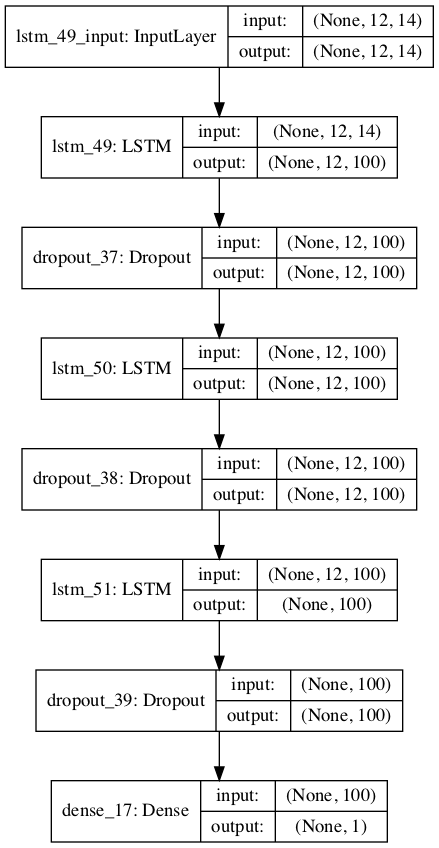

In [18]:
lstm_model = load_model('model/lstm_model_w_low_test_reg_2020_08_31.h5')

# keras.utils.vis_utils.pydot = pydot
plot_model(lstm_model, to_file = 'images/lstm_model.png', show_shapes = True,)# show_layer_names = True)

### The S&P 500 LSTM univariate model

To be able to compare the predicted returns of the company-specific multivariate LSTM model with the predicted S&P 500 returns, a specific LSTM model needs to built. There is no analyst estimates data for the S&P 500 so the model will be a univariate LSTM model. The same hyperparameters will be used as the company-specific model.

In [19]:
def build_spx_lstm_model(
    rate_dropout = 0.2,
    n_nodes_list = (100,100,100),
    n_input = 12,
    lr = 0.0001,
    act_funct = 'relu', 
    loss = 'mean_squared_error'
):

    seq_bool = [True] * len(n_nodes_list)
    seq_bool[-1] = False
    
    spx_lstm_model = Sequential()
    
    for layer in range(len(n_nodes_list)):
        if layer == 0:
            spx_lstm_model.add(LSTM(
                n_nodes_list[layer], 
                activation = act_funct, 
                return_sequences = seq_bool[layer], 
                input_shape = (n_input, 1)
            ))
        else:
            spx_lstm_model.add(LSTM(
                n_nodes_list[layer], 
                activation = act_funct, 
                return_sequences = seq_bool[layer]
            ))
        if rate_dropout != 0.0:
            spx_lstm_model.add(Dropout(rate = rate_dropout))
    
    
    
    spx_lstm_model.add(Dense(1))


    opt = Adam(learning_rate = lr)
    spx_lstm_model.compile(optimizer = opt, loss = loss)
    
    return spx_lstm_model

spx_lstm_model = build_spx_lstm_model()

__There are now 2 approaches to predicting the share prices:__
1. The original trained weights can be used for each company. This means that the model does not need to be retrained at every interval. But it does mean the weights and biases are relevant for every company
2. Alternatively, the model could be retrained every month for the respective company. The hyperparameters would remain the same. 

### Approach 1 - Retraining the model for every month/company

__Steps:__ 
1. Identify the company(s) to be considered for the current month and build the respective dataframe for that company
2. Fit the data to the model using the previous 12 months of data. Or can I use more? Depends on whether there is data history for that company 
3. Predict the next months performance:
    1. for the company(s)
    2. for the S&P 500 
4. Determine which of the 2 is expected to perform better and: 
    1. Take a long position in the better performer
    2. Take a short position in the other
5. Measure the actual performance for the month to compare with the strategies predicted performance. 
6. Compare the strategy's performance to a simple buy-and-hold, by performing a thorough analysis of all the metrics (MDD, Sharpe, etc)


In [20]:
def create_lstm_model(
    n_nodes_list, 
    n_input, 
    n_cols, 
    rate_dropout, 
    lr, 
    act_funct = 'relu', 
    loss = 'mean_squared_error'
):
    
    seq_bool = [True] * len(n_nodes_list)
    seq_bool[-1] = False
    
    model = Sequential()
    
    for layer in range(len(n_nodes_list)):
        if layer == 0:
            model.add(LSTM(
                n_nodes_list[layer], 
                activation = act_funct, 
                return_sequences = seq_bool[layer], 
                input_shape = (n_input, n_cols)
            ))
        else:
            model.add(LSTM(
                n_nodes_list[layer], 
                activation = act_funct, 
                return_sequences = seq_bool[layer]
            ))
        if rate_dropout != 0.0:
            model.add(Dropout(rate = rate_dropout))
            
            
    
    lstm_model.add(Dense(1))
    opt = Adam(learning_rate = lr)
    lstm_model.compile(optimizer = opt, loss = loss)
    
    return lstm_model

_Why can't I just use the predict method without having to retrain the models every month?_

Because the model trained in the hyperparameter search section is unique to the company tested in that isolated case and time period. It is worth training the parameters (ie. weights/biases/gates etc...) for each new company and time period. 

In [21]:
spx_monthly_df = spx_df.resample('M').last()

In [22]:
len(dates) - 48

12

In [23]:
def predict_monthly_returns(
    n_input = 12,
    batch_size = 1,
    epochs = 100, # too few considering the smaller data size? 
    n_nodes_list = (100,100,100),
    rate_dropout = 0.2,
    lr = 0.001
):

    early_stopping = EarlyStopping(monitor = 'loss', patience = 25)

    predictions = []
    spx_predictions = []

    ## Loop through each month
    for m in range(len(dates) - 48):

        ## Identify the company under review and build the dataset
        isin, ric, name, error = best_company_dict[dates[m+48]]
        company_df = build_lstm_dataset(ric, isin)
        company_df = company_df.fillna(method = 'ffill') # some longer dated estimates data can be missing
        train_df = company_df.loc[dates[m]:dates[m+47], :]
        test_df = company_df.loc[dates[m+48], :]
        n_cols = train_df.shape[1]

        ## Create the matching time series data for SPX
        spx_train_df = copy.deepcopy(spx_monthly_df[dates[m]:dates[m+47]])
        spx_test_df = copy.deepcopy(spx_monthly_df[dates[m+48]])

        ## Scale the company data
        scaler = MinMaxScaler()
        scaler.fit(train_df) 
        scaled_train_df = scaler.transform(train_df) 
        scaled_test_df = scaler.transform(test_df)

        ## Scale the SPX data
        spx_scaler = MinMaxScaler()
        spx_scaler.fit(spx_train_df)
        scaled_spx_train_df = spx_scaler.transform(spx_train_df)
        scaled_spx_test_df = spx_scaler.transform(spx_train_df)

        ## Fit the training data to the model
        generator = TimeseriesGenerator(
            scaled_train_df, 
            scaled_train_df[:, 11], 
            length = n_input, 
            batch_size = batch_size
        )
        lstm_model = create_lstm_model(n_nodes_list, n_input, n_cols, rate_dropout, lr)
        lstm_model.fit_generator(
            generator, 
            epochs = epochs, 
            callbacks = [early_stopping]
        )

        # Fit the training data for the SPX model
        spx_generator = TimeseriesGenerator(
            scaled_spx_train_df, 
            scaled_spx_train_df, 
            length = n_input, 
            batch_size = batch_size
        )
        spx_lstm_model.fit_generator(
            spx_generator, 
            epochs = epochs, 
            callbacks = [early_stopping]
        )

        ## Generate Company Predictions
        eval_data = scaled_train_df[-n_input:].reshape((1, n_input, n_cols))
        prediction = lstm_model.predict(eval_data)[0]
        
        prediction_temp = np.zeros((1, 14))
        prediction_temp[:, 11] = prediction
    
        true_prediction = scaler.inverse_transform(prediction_temp.reshape(1, -1))[0]
        return_prediction = true_prediction[11] / train_df.iloc[-1, 11] - 1 # column 11 is 'Price'
        return_actual = test_df.iloc[0, 11] / train_df.iloc[-1, 11] - 1
        predictions.append([dates[m+48], name, return_prediction, return_actual])


        ## Generate SPX Predictions
        spx_eval_data = scaled_spx_train_df[-n_input:].reshape((1, n_input, 1))
        spx_prediction = spx_lstm_model.predict(spx_eval_data)[0]
        spx_true_prediction = spx_scaler.inverse_transform(spx_prediction.reshape(1, -1))[0]
        spx_return_prediction = spx_true_prediction / spx_train_df.iloc[-1] - 1
        spx_predictions.append([dates[m+48], spx_return_prediction])
        
    return predictions, spx_predictions

In [24]:
predictions, spx_predictions = predict_monthly_returns()

Epoch 1/100
36/36 [==============================] - 2s 55ms/step - loss: 0.2818
Epoch 2/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0864
Epoch 3/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0639
Epoch 4/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0637
Epoch 5/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0681
Epoch 6/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0710
Epoch 7/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0489
Epoch 8/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0480
Epoch 9/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0608
Epoch 10/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0614
Epoch 11/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0523
Epoch 12/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0447
Epoch 13/100
36/36 [=====

36/36 [==============================] - 2s 51ms/step - loss: 0.4786
Epoch 2/100
36/36 [==============================] - 1s 15ms/step - loss: 0.3775
Epoch 3/100
36/36 [==============================] - 1s 15ms/step - loss: 0.1649
Epoch 4/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0687
Epoch 5/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0699
Epoch 6/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0678
Epoch 7/100
36/36 [==============================] - 0s 13ms/step - loss: 0.0804
Epoch 8/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0726
Epoch 9/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0666
Epoch 10/100
36/36 [==============================] - 0s 13ms/step - loss: 0.0688
Epoch 11/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0693
Epoch 12/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0678
Epoch 13/100
36/36 [=================

36/36 [==============================] - 3s 71ms/step - loss: 0.5828
Epoch 2/100
36/36 [==============================] - 1s 19ms/step - loss: 0.1530
Epoch 3/100
36/36 [==============================] - 1s 19ms/step - loss: 0.0947
Epoch 4/100
36/36 [==============================] - 1s 19ms/step - loss: 0.0636
Epoch 5/100
36/36 [==============================] - 1s 19ms/step - loss: 0.0503
Epoch 6/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0493
Epoch 7/100
36/36 [==============================] - 1s 19ms/step - loss: 0.0406
Epoch 8/100
36/36 [==============================] - 1s 19ms/step - loss: 0.0315
Epoch 9/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0321
Epoch 10/100
36/36 [==============================] - 1s 19ms/step - loss: 0.0298
Epoch 11/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0247
Epoch 12/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0314
Epoch 13/100
36/36 [=================

36/36 [==============================] - 0s 11ms/step - loss: 0.0348
Epoch 2/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0307
Epoch 3/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0313
Epoch 4/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0285
Epoch 5/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0289
Epoch 6/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0277
Epoch 7/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0334
Epoch 8/100
36/36 [==============================] - 0s 13ms/step - loss: 0.0260
Epoch 9/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0259
Epoch 10/100
36/36 [==============================] - 0s 13ms/step - loss: 0.0276
Epoch 11/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0290
Epoch 12/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0261
Epoch 13/100
36/36 [=================

36/36 [==============================] - 1s 19ms/step - loss: 0.0158
Epoch 55/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0227
Epoch 56/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0199
Epoch 57/100
36/36 [==============================] - 1s 19ms/step - loss: 0.0109
Epoch 58/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0111
Epoch 59/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0117
Epoch 60/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0113
Epoch 61/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0073
Epoch 62/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0089
Epoch 63/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0117
Epoch 64/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0099
Epoch 65/100
36/36 [==============================] - 1s 20ms/step - loss: 0.0079
Epoch 1/100
36/36 [==========

36/36 [==============================] - 1s 14ms/step - loss: 0.0111
Epoch 6/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0169
Epoch 7/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0134
Epoch 8/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0119
Epoch 9/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0107
Epoch 10/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0240
Epoch 11/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0139
Epoch 12/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0103
Epoch 13/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0088
Epoch 14/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0090
Epoch 15/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0119
Epoch 16/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0092
Epoch 17/100
36/36 [=============

36/36 [==============================] - 1s 14ms/step - loss: 0.0202
Epoch 37/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0206
Epoch 38/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0141
Epoch 39/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0221
Epoch 40/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0106
Epoch 41/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0200
Epoch 42/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0136
Epoch 43/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0126
Epoch 44/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0184
Epoch 45/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0239
Epoch 46/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0159
Epoch 47/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0151
Epoch 48/100
36/36 [=========

36/36 [==============================] - 0s 14ms/step - loss: 0.0121
Epoch 72/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0122
Epoch 73/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0127
Epoch 74/100
36/36 [==============================] - 0s 13ms/step - loss: 0.0118
Epoch 75/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0103
Epoch 76/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0141
Epoch 77/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0129
Epoch 78/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0124
Epoch 79/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0177
Epoch 80/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0176
Epoch 81/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0128
Epoch 82/100
36/36 [==============================] - 0s 13ms/step - loss: 0.0133
Epoch 83/100
36/36 [=========

36/36 [==============================] - 0s 11ms/step - loss: 0.0099
Epoch 72/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0218
Epoch 73/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0130
Epoch 74/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0122
Epoch 75/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0127
Epoch 76/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0120
Epoch 77/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0112
Epoch 78/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0120
Epoch 79/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0090
Epoch 80/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0145
Epoch 81/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0138
Epoch 82/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0134
Epoch 83/100
36/36 [=========

36/36 [==============================] - 0s 11ms/step - loss: 0.0115
Epoch 13/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0085
Epoch 14/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0094
Epoch 15/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0112
Epoch 16/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0136
Epoch 17/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0081
Epoch 18/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0103
Epoch 19/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0084
Epoch 20/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0128
Epoch 21/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0122
Epoch 22/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0103
Epoch 23/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0130
Epoch 24/100
36/36 [=========

36/36 [==============================] - 1s 14ms/step - loss: 0.0167
Epoch 26/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0130
Epoch 27/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0161
Epoch 28/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0169
Epoch 29/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0197
Epoch 30/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0115
Epoch 31/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0153
Epoch 32/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0171
Epoch 33/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0096
Epoch 34/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0199
Epoch 35/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0156
Epoch 36/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0186
Epoch 37/100
36/36 [=========

36/36 [==============================] - 0s 10ms/step - loss: 0.0082
Epoch 26/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0057
Epoch 27/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0095
Epoch 28/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0081
Epoch 29/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0083
Epoch 30/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0061
Epoch 31/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0095
Epoch 32/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0108
Epoch 33/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0122
Epoch 34/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0112
Epoch 35/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0064
Epoch 36/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0081
Epoch 37/100
36/36 [=========

36/36 [==============================] - 0s 14ms/step - loss: 0.0102
Epoch 88/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0227
Epoch 89/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0112
Epoch 90/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0155
Epoch 91/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0112
Epoch 92/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0087
Epoch 93/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0093
Epoch 94/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0219
Epoch 95/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0116
Epoch 96/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0119
Epoch 97/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0096
Epoch 98/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0094
Epoch 99/100
36/36 [=========

36/36 [==============================] - 1s 14ms/step - loss: 0.0145
Epoch 43/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0246
Epoch 44/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0075
Epoch 45/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0078
Epoch 46/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0109
Epoch 47/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0083
Epoch 48/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0073
Epoch 49/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0085
Epoch 50/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0089
Epoch 51/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0091
Epoch 52/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0102
Epoch 53/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0103
Epoch 54/100
36/36 [=========

36/36 [==============================] - 0s 10ms/step - loss: 0.0071
Epoch 43/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0058
Epoch 44/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0098
Epoch 45/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0089
Epoch 46/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0052
Epoch 47/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0072
Epoch 48/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0055
Epoch 49/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0053
Epoch 50/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0082
Epoch 51/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0080
Epoch 52/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0091
Epoch 53/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0092
Epoch 54/100
36/36 [=========

36/36 [==============================] - 1s 14ms/step - loss: 0.0066
Epoch 61/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0106
Epoch 62/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0080
Epoch 63/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0082
Epoch 64/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0035
Epoch 65/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0045
Epoch 66/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0095
Epoch 67/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0141
Epoch 68/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0089
Epoch 69/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0061
Epoch 70/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0093
Epoch 71/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0036
Epoch 72/100
36/36 [=========

36/36 [==============================] - 1s 14ms/step - loss: 0.0077
Epoch 50/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0091
Epoch 51/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0052
Epoch 52/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0072
Epoch 53/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0123
Epoch 54/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0052
Epoch 55/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0048
Epoch 56/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0056
Epoch 57/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0068
Epoch 58/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0073
Epoch 59/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0094
Epoch 60/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0071
Epoch 61/100
36/36 [=========

36/36 [==============================] - 1s 15ms/step - loss: 0.0127
Epoch 4/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0125
Epoch 5/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0103
Epoch 6/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0093
Epoch 7/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0085
Epoch 8/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0071
Epoch 9/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0069
Epoch 10/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0098
Epoch 11/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0117
Epoch 12/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0139
Epoch 13/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0091
Epoch 14/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0066
Epoch 15/100
36/36 [===============

In [25]:
predictions

[['2009-01', 'Johnson & Johnson', -0.003642808552352994, -0.03576803207397461],
 ['2009-02', 'Johnson & Johnson', 0.03013404465770564, -0.13329863548278809],
 ['2009-03', 'Johnson & Johnson', 0.13705928008846513, 0.05199992656707764],
 ['2009-04', 'Johnson & Johnson', 0.06414625459900614, -0.004562675952911377],
 ['2009-05', 'Johnson & Johnson', -0.016685525280273894, 0.05347597599029541],
 ['2009-06', 'Johnson & Johnson', -0.03171287502563325, 0.0297316312789917],
 ['2009-07', 'Johnson & Johnson', 0.17184496143118833, 0.07200706005096436],
 ['2009-08', 'Johnson & Johnson', 0.006554291757242536, -0.007390379905700684],
 ['2009-09', 'Johnson & Johnson', 0.000932596749142478, 0.0074454545974731445],
 ['2009-10',
  'Johnson & Johnson',
  -0.030895997793767283,
  -0.030218422412872314],
 ['2009-11', 'Johnson & Johnson', 0.0055904399554527195, 0.06418287754058838],
 ['2009-12', 'Johnson & Johnson', -0.014959850265599872, 0.024984121322631836]]

Now the predicted returns and the actual returns can be collected with a dataframe. This is done for both the company returns and the S&P 500 returns. This allows for a simple check to see if the predicted company return is higher than the predicted S&P return which is an important step in the trading strategy logic. 

In [26]:
test_returns = spx_monthly_df.pct_change().loc[dates[48]:].values.flatten() # 12 month training periof

predictions_df = pd.DataFrame({
    'company_returns_pred': [x[2] for x in predictions], 
    'company_returns_actual': [x[3] for x in predictions],
    'spx_returns_pred': [x[1].values[0] for x in spx_predictions],
    'spx_returns_actual': test_returns
    
    },
    index = [x[0] for x in predictions]
)

predictions_df['long_company'] = predictions_df['company_returns_pred'] > predictions_df['spx_returns_pred']
predictions_df.head()

,company_returns_pred,company_returns_actual,spx_returns_pred,spx_returns_actual,long_company
2009-01,-0.003643,-0.035768,0.306091,-0.085657,False
2009-02,0.030134,-0.133299,0.233748,-0.109931,False
2009-03,0.137059,0.052000,-0.065757,0.085405,True
2009-04,0.064146,-0.004563,-0.228536,0.093925,True
2009-05,-0.016686,0.053476,-0.066690,0.053081,True


With the `predictions_df` dataframe built, it is easy now to determine the trading strategy's performance. For each month, the returns of the long and short positions are grouped together. The net return of the long and short portfolios is then determined to give the overall strategy performance. 

Both the predicted strategy returns and actual strategy returns are calculated. 

In [27]:
long_pred = []
short_pred = [] 
long_act = []
short_act = []

for month in predictions_df.index:
    if predictions_df.loc[month, 'long_company']:
        long_pred.append(predictions_df.loc[month, 'company_returns_pred'])
        short_pred.append(predictions_df.loc[month, 'spx_returns_pred'])
        long_act.append(predictions_df.loc[month, 'company_returns_actual'])
        short_act.append(predictions_df.loc[month, 'spx_returns_actual'])
    else:
        long_pred.append(predictions_df.loc[month, 'spx_returns_pred'])
        short_pred.append(predictions_df.loc[month, 'company_returns_pred'])
        long_act.append(predictions_df.loc[month, 'spx_returns_actual'])
        short_act.append(predictions_df.loc[month, 'company_returns_actual'])
        

predicted_strategy_return_df = pd.DataFrame({
    'Long': long_pred,
    'Short': short_pred,
    'Net': np.array(long_pred) - np.array(short_pred)
    },
    index = predictions_df.index,
)

actual_strategy_return_df = pd.DataFrame({
    'Long': long_act,
    'Short': short_act,
    'Net': np.array(long_act) - np.array(short_act)
    },
    index = predictions_df.index,
)

## Performance Evaluation

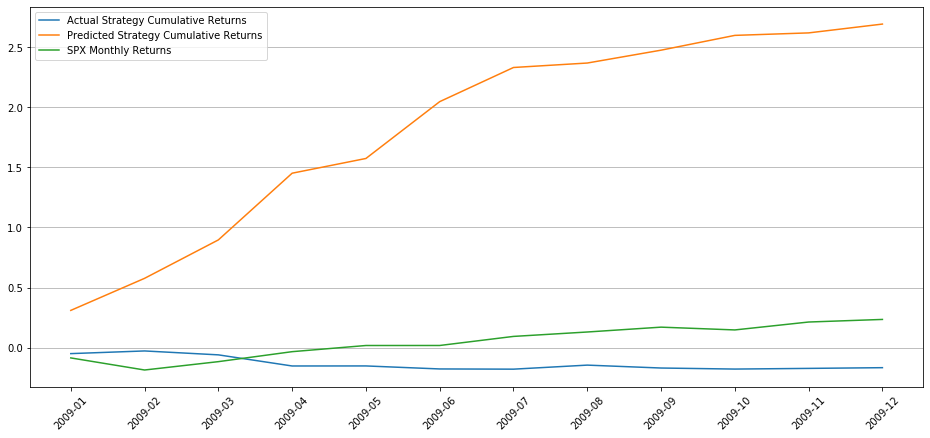

In [28]:
plt.figure(figsize = (16, 7))
plt.plot(np.cumprod(1 + actual_strategy_return_df['Net']) - 1, label = 'Actual Strategy Cumulative Returns')
plt.plot(np.cumprod(1 + predicted_strategy_return_df['Net']) - 1, label = 'Predicted Strategy Cumulative Returns')
plt.plot(np.cumprod(1 + test_returns) - 1, label = 'SPX Monthly Returns')
plt.legend(loc = 'best')
plt.grid(axis = 'y')
plt.xticks(rotation = 45)
plt.show()

Create some functions to measure the strategy performance by the various metrics discussed in the State-of-the-Art section. The metrics are Maximum Drawdown, Maximum Drawdown duration, APR, Sharpe Ratio and the Pearson correlation.

In [29]:
def apr(ts):
    return np.prod(1 + ts) ** (12 / len(ts)) - 1 
    
def sharpe(ts):
    return np.sqrt(12) * np.mean(ts) / np.std(ts)

def max_dd(ts):
    cum_ret = np.cumprod(1 + ts) - 1
    
    high_water_mark = np.zeros(cum_ret.shape)
    draw_down = np.zeros(cum_ret.shape)
    draw_down_duration = np.zeros(cum_ret.shape)
    
    for t in np.arange(1, cum_ret.shape[0]):
        high_water_mark[t] = np.maximum(high_water_mark[t - 1], cum_ret[t])
        draw_down[t] = (1 + cum_ret[t]) / (1 + high_water_mark[t]) - 1
        if draw_down[t] == 0:
            draw_down_duration[t] = 0
        else:
            draw_down_duration[t] = draw_down_duration[t - 1] + 1 # adds another day
    
    max_dd, i = np.min(draw_down), np.argmin(draw_down) # 'draw_down' < 0 always
    max_ddd = np.max(draw_down_duration)
    
    return max_dd, max_ddd, i

In [30]:
perf_metrics_df = pd.DataFrame()

perf_metrics_df.loc['APR', 'Strategy'] = apr(actual_strategy_return_df['Net'])
perf_metrics_df.loc['APR', 'S&P'] = apr(test_returns)
perf_metrics_df.loc['Sharpe_Ratio', 'Strategy'] = sharpe(actual_strategy_return_df['Net'])
perf_metrics_df.loc['Sharpe_Ratio', 'S&P'] = sharpe(test_returns)
perf_metrics_df.loc['Max_DD', 'Strategy'] = max_dd(actual_strategy_return_df['Net'])[0]
perf_metrics_df.loc['Max_DD', 'S&P'] = max_dd(test_returns)[0]
perf_metrics_df.loc['Max_DD_Duration', 'Strategy'] = max_dd(actual_strategy_return_df['Net'])[1]
perf_metrics_df.loc['Max_DD_Duration', 'S&P'] = max_dd(test_returns)[1]

perf_metrics_df

,Strategy,S&P
APR,-0.166847,0.234542
Sharpe_Ratio,-1.420631,1.104094
Max_DD,-0.179186,-0.186172
Max_DD_Duration,11.000000,3.000000


It could be the case that the strategy out/underperformed by luck. It is also useful to measure how well the strategy performed vs its predicted performance, much in the same way the autoencoder and lstm models were originally assessed. 

A useful metric for this analysis could be to consider the MSE, although this may offer little information on its own. However if different models were to be created, such as different mixes of companies, it might be useful to compare MSE between the different strategies. 

It might also be useful to perform a t-test to determine whether the difference between the mean of the predicted strategy returns and the mean of the actual strategy returns is statistically significant. 

https://towardsdatascience.com/inferential-statistics-series-t-test-using-numpy-2718f8f9bf2f

In [31]:
strategy_mse = mean_squared_error(actual_strategy_return_df['Net'], predicted_strategy_return_df['Net'])
strategy_mse

0.03620321239569281

In [32]:
t_stat, p_val = stats.ttest_ind(actual_strategy_return_df['Net'], predicted_strategy_return_df['Net'])
t_stat, p_val # a large p-value indicates the actual and predicted are not the same at 95%

(-3.9364287326839693, 0.0007041707680210345)

## Again, without dropout rate

In [33]:
spx_lstm_model2 = build_spx_lstm_model(rate_dropout = 0.0)
predictions2, spx_predictions2 = predict_monthly_returns(rate_dropout = 0.0)

Epoch 1/100
36/36 [==============================] - 2s 61ms/step - loss: 0.0798
Epoch 2/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0625
Epoch 3/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0498
Epoch 4/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0382
Epoch 5/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0363
Epoch 6/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0396
Epoch 7/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0291
Epoch 8/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0456
Epoch 9/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0349
Epoch 10/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0377
Epoch 11/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0817
Epoch 12/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0601
Epoch 13/100
36/36 [=====

36/36 [==============================] - 0s 10ms/step - loss: 0.0114
Epoch 18/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0094
Epoch 19/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0106
Epoch 20/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0111
Epoch 21/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0107
Epoch 22/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0096
Epoch 23/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0119
Epoch 24/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0094
Epoch 25/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0089
Epoch 26/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0090
Epoch 27/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0083
Epoch 28/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0075
Epoch 29/100
36/36 [=========

36/36 [==============================] - 1s 15ms/step - loss: 0.0307
Epoch 18/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0322
Epoch 19/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0255
Epoch 20/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0569
Epoch 21/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0300
Epoch 22/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0271
Epoch 23/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0236
Epoch 24/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0269
Epoch 25/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0235
Epoch 26/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0735
Epoch 27/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0256
Epoch 28/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0253
Epoch 29/100
36/36 [=========

36/36 [==============================] - 1s 15ms/step - loss: 0.1610
Epoch 11/100
36/36 [==============================] - 1s 15ms/step - loss: 0.1266
Epoch 12/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0997
Epoch 13/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0788
Epoch 14/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0624
Epoch 15/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0524
Epoch 16/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0455
Epoch 17/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0415
Epoch 18/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0397
Epoch 19/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0377
Epoch 20/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0354
Epoch 21/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0281
Epoch 22/100
36/36 [=========

36/36 [==============================] - 1s 15ms/step - loss: 0.0235
Epoch 18/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0277
Epoch 19/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0217
Epoch 20/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0229
Epoch 21/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0247
Epoch 22/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0264
Epoch 23/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0295
Epoch 24/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0316
Epoch 25/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0217
Epoch 26/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0366
Epoch 27/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0248
Epoch 28/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0275
Epoch 29/100
36/36 [=========

36/36 [==============================] - 1s 14ms/step - loss: 0.0222
Epoch 33/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0129
Epoch 34/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0251
Epoch 35/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0228
Epoch 36/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0206
Epoch 37/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0196
Epoch 38/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0139
Epoch 39/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0254
Epoch 40/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0239
Epoch 41/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0403
Epoch 42/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0451
Epoch 43/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0436
Epoch 44/100
36/36 [=========

36/36 [==============================] - 0s 10ms/step - loss: 0.0080
Epoch 33/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0083
Epoch 34/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0062
Epoch 35/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0058
Epoch 36/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0087
Epoch 37/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0048
Epoch 38/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0070
Epoch 39/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0054
Epoch 40/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0060
Epoch 41/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0060
Epoch 42/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0038
Epoch 43/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0048
Epoch 44/100
36/36 [=========

36/36 [==============================] - 1s 15ms/step - loss: 0.0163
Epoch 3/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0154
Epoch 4/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0112
Epoch 5/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0112
Epoch 6/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0101
Epoch 7/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0101
Epoch 8/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0151
Epoch 9/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0245
Epoch 10/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0128
Epoch 11/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0177
Epoch 12/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0347
Epoch 13/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0128
Epoch 14/100
36/36 [================

36/36 [==============================] - 0s 10ms/step - loss: 0.0055
Epoch 45/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0050
Epoch 46/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0040
Epoch 47/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0045
Epoch 48/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0059
Epoch 49/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0027
Epoch 50/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0052
Epoch 51/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0047
Epoch 52/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0068
Epoch 53/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0068
Epoch 54/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0022
Epoch 55/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0028
Epoch 56/100
36/36 [=========

36/36 [==============================] - 0s 10ms/step - loss: 0.0052
Epoch 12/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0054
Epoch 13/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0076
Epoch 14/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0062
Epoch 15/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0059
Epoch 16/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0064
Epoch 17/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0044
Epoch 18/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0051
Epoch 19/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0089
Epoch 20/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0049
Epoch 21/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0040
Epoch 22/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0060
Epoch 23/100
36/36 [=========

36/36 [==============================] - 1s 14ms/step - loss: 0.0205
Epoch 83/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0110
Epoch 84/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0155
Epoch 85/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0207
Epoch 86/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0191
Epoch 87/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0172
Epoch 88/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0157
Epoch 89/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0227
Epoch 90/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0136
Epoch 91/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0133
Epoch 92/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0118
Epoch 93/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0152
Epoch 94/100
36/36 [=========

36/36 [==============================] - 1s 14ms/step - loss: 0.0182
Epoch 25/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0113
Epoch 26/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0080
Epoch 27/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0083
Epoch 28/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0138
Epoch 29/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0093
Epoch 30/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0087
Epoch 31/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0081
Epoch 32/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0137
Epoch 33/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0107
Epoch 34/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0088
Epoch 35/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0088
Epoch 36/100
36/36 [=========

36/36 [==============================] - 0s 10ms/step - loss: 0.0041
Epoch 25/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0040
Epoch 26/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0035
Epoch 27/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0053
Epoch 28/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0068
Epoch 29/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0049
Epoch 30/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0043
Epoch 31/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0070
Epoch 32/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0082
Epoch 33/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0059
Epoch 34/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0044
Epoch 35/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0031
Epoch 36/100
36/36 [=========

36/36 [==============================] - 0s 10ms/step - loss: 0.0033
Epoch 42/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0041
Epoch 43/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0038
Epoch 44/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0068
Epoch 1/100
36/36 [==============================] - 2s 66ms/step - loss: 0.9268
Epoch 2/100
36/36 [==============================] - 1s 15ms/step - loss: 0.4155
Epoch 3/100
36/36 [==============================] - 1s 15ms/step - loss: 0.2048
Epoch 4/100
36/36 [==============================] - 1s 14ms/step - loss: 0.1003
Epoch 5/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0647
Epoch 6/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0556
Epoch 7/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0546
Epoch 8/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0546
Epoch 9/100
36/36 [==================

36/36 [==============================] - 1s 15ms/step - loss: 0.0143
Epoch 98/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0183
Epoch 99/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0146
Epoch 100/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0109
Epoch 1/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0090
Epoch 2/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0076
Epoch 3/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0058
Epoch 4/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0039
Epoch 5/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0039
Epoch 6/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0043
Epoch 7/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0035
Epoch 8/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0060
Epoch 9/100
36/36 [=================

In [34]:
test_returns = spx_monthly_df.pct_change().loc[dates[48]:].values.flatten() # 12 month training periof

predictions_df2 = pd.DataFrame({
    'company_returns_pred': [x[2] for x in predictions2], 
    'company_returns_actual': [x[3] for x in predictions2],
    'spx_returns_pred': [x[1].values[0] for x in spx_predictions2],
    'spx_returns_actual': test_returns
    
    },
    index = [x[0] for x in predictions2]
)

predictions_df2['long_company'] = predictions_df2['company_returns_pred'] > predictions_df2['spx_returns_pred']
predictions_df2.head()

,company_returns_pred,company_returns_actual,spx_returns_pred,spx_returns_actual,long_company
2009-01,-0.024985,-0.035768,-0.115454,-0.085657,True
2009-02,0.053003,-0.133299,-0.031795,-0.109931,True
2009-03,0.241282,0.052000,0.119733,0.085405,True
2009-04,0.153966,-0.004563,0.060448,0.093925,True
2009-05,0.069797,0.053476,0.018801,0.053081,True


In [35]:
long_pred2 = []
short_pred2 = [] 
long_act2 = []
short_act2 = []

for month in predictions_df2.index:
    if predictions_df2.loc[month, 'long_company']:
        long_pred2.append(predictions_df2.loc[month, 'company_returns_pred'])
        short_pred2.append(predictions_df2.loc[month, 'spx_returns_pred'])
        long_act2.append(predictions_df2.loc[month, 'company_returns_actual'])
        short_act2.append(predictions_df2.loc[month, 'spx_returns_actual'])
    else:
        long_pred2.append(predictions_df2.loc[month, 'spx_returns_pred'])
        short_pred2.append(predictions_df2.loc[month, 'company_returns_pred'])
        long_act2.append(predictions_df2.loc[month, 'spx_returns_actual'])
        short_act2.append(predictions_df2.loc[month, 'company_returns_actual'])
        

predicted_strategy_return_df2 = pd.DataFrame({
    'Long': long_pred2,
    'Short': short_pred2,
    'Net': np.array(long_pred2) - np.array(short_pred2)
    },
    index = predictions_df2.index,
)

actual_strategy_return_df2 = pd.DataFrame({
    'Long': long_act2,
    'Short': short_act2,
    'Net': np.array(long_act2) - np.array(short_act2)
    },
    index = predictions_df2.index,
)

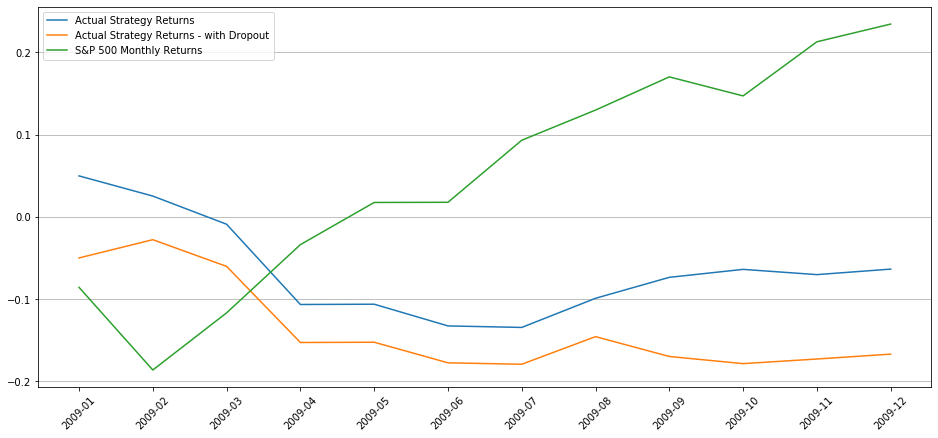

In [54]:
plt.figure(figsize = (16, 7))
plt.plot(np.cumprod(1 + actual_strategy_return_df2['Net']) - 1, label = 'Actual Strategy Returns')
plt.plot(np.cumprod(1 + actual_strategy_return_df['Net']) - 1, label = 'Actual Strategy Returns - with Dropout')
# plt.plot(np.cumprod(1 + predicted_strategy_return_df2['Net']) - 1, label = 'Predicted')
plt.plot(np.cumprod(1 + test_returns) - 1, label = 'S&P 500 Monthly Returns')
plt.legend(loc = 'best')
plt.grid(axis = 'y')
plt.xticks(rotation = 45)
plt.show()

In [55]:
perf_metrics_df2 = pd.DataFrame()

perf_metrics_df2.loc['APR', 'Strategy'] = apr(actual_strategy_return_df2['Net'])
perf_metrics_df2.loc['APR', 'Strategy - with DO'] = apr(actual_strategy_return_df['Net'])
perf_metrics_df2.loc['APR', 'S&P'] = apr(test_returns)
perf_metrics_df2.loc['Sharpe_Ratio', 'Strategy'] = sharpe(actual_strategy_return_df2['Net'])
perf_metrics_df2.loc['Sharpe_Ratio', 'Strategy - with DO'] = sharpe(actual_strategy_return_df['Net'])
perf_metrics_df2.loc['Sharpe_Ratio', 'S&P'] = sharpe(test_returns)
perf_metrics_df2.loc['Max_DD', 'Strategy'] = max_dd(actual_strategy_return_df2['Net'])[0]
perf_metrics_df2.loc['Max_DD', 'Strategy - with DO'] = max_dd(actual_strategy_return_df['Net'])[0]
perf_metrics_df2.loc['Max_DD', 'S&P'] = max_dd(test_returns)[0]
perf_metrics_df2.loc['Max_DD_Duration', 'Strategy'] = max_dd(actual_strategy_return_df2['Net'])[1]
perf_metrics_df2.loc['Max_DD_Duration', 'Strategy - with DO'] = max_dd(actual_strategy_return_df['Net'])[1]
perf_metrics_df2.loc['Max_DD_Duration', 'S&P'] = max_dd(test_returns)[1]
perf_metrics_df2.loc['Correlation', 'Strategy'] = np.corrcoef(actual_strategy_return_df2['Net'], test_returns)[0,1]
perf_metrics_df2.loc['Correlation', 'Strategy - with DO'] = np.corrcoef(actual_strategy_return_df['Net'], test_returns)[0,1]
perf_metrics_df2.loc['Correlation', 'S&P'] = np.corrcoef(test_returns, test_returns)[0,1]

perf_metrics_df2

,Strategy,Strategy - with DO,S&P
APR,-0.063469,-0.166847,0.234542
Sharpe_Ratio,-0.432001,-1.420631,1.104094
Max_DD,-0.155812,-0.179186,-0.186172
Max_DD_Duration,10.000000,11.000000,3.000000
Correlation,-0.390626,-0.231764,1.000000


In [56]:
perf_metrics_df2.to_csv('../Data/2005-2010_strategy_performance.csv')

In [60]:
lstmdo_r2 = r2_score(actual_strategy_return_df['Net'], predicted_strategy_return_df['Net'])
lstm_r2 = r2_score(actual_strategy_return_df2['Net'], predicted_strategy_return_df2['Net'])
lstmdo_r2, lstm_r2

(-28.146400591092668, -4.569878577454601)

In [57]:
t_stat, p_val

(-3.9364287326839693, 0.0007041707680210345)

In [39]:
t_stat2, p_val2 = stats.ttest_ind(actual_strategy_return_df2['Net'], predicted_strategy_return_df2['Net'])
t_stat2, p_val2 # a large p-value indicates the actual and predicted are not the same at 95%

(-4.42976726004773, 0.00021115944695174904)

In [48]:
lstm_preds_class = predictions_df2['company_returns_pred'] > predictions_df2['spx_returns_pred']
lstm_act_class = predictions_df2['company_returns_actual'] > predictions_df2['spx_returns_actual']

In [49]:
lstmdo_preds_class = predictions_df['company_returns_pred'] > predictions_df['spx_returns_pred']
lstmdo_act_class = predictions_df['company_returns_actual'] > predictions_df['spx_returns_actual']

In [50]:
confusion_matrix(lstm_act_class, lstm_preds_class)

array([[3, 4],
       [2, 3]])

In [51]:
lstm_acc = accuracy_score(lstm_act_class, lstm_preds_class)
lstm_pre = precision_score(lstm_act_class, lstm_preds_class)
lstm_rec = recall_score(lstm_act_class, lstm_preds_class)

lstm_acc, lstm_pre, lstm_rec

(0.5, 0.42857142857142855, 0.6)

In [52]:
confusion_matrix(lstmdo_act_class, lstmdo_preds_class)

array([[2, 5],
       [2, 3]])

In [53]:
lstmdo_acc = accuracy_score(lstmdo_act_class, lstmdo_preds_class)
lstmdo_pre = precision_score(lstmdo_act_class, lstmdo_preds_class)
lstmdo_rec = recall_score(lstmdo_act_class, lstmdo_preds_class)

lstmdo_acc, lstmdo_pre, lstmdo_rec

(0.4166666666666667, 0.375, 0.6)